In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm.notebook import tqdm
import ephem

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'ibt_vars2keep':    ['usa_lon', 'usa_lat', 'usa_pres', 'usa_wind', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw', 'storm_speed', 'storm_dir', 'name', 'sid'],
    'ibt_info2keep':    ['sid', 'basin', 'name', 'usa_atcf_id', 'usa_agency', 'iso_time', 'usa_status'],
}

PTHS = {
    'sar_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_UC_DIAGNOSTIC/01_PLOT_DIAGNOSTIC/',
    'ibt_pth': '/home/arthur/data/tropical_cyclones/ibtracs/24032025/IBTrACS.ALL.v04r01.nc',
}

### Open data
# SAR
dsg  = xr.open_dataset(PTHS['sar_pth'])

# IBTrACS
ds_ibt_all = xr.open_dataset(PTHS['ibt_pth'])
# Select variables
ds_ibt                        = ds_ibt_all[PRMS['ibt_vars2keep']]
ds_ibt[PRMS['ibt_info2keep']] = ds_ibt_all[PRMS['ibt_info2keep']].astype(str, copy=False) # Convert byte arrays to strings
# Select dates
# start_date                    = np.datetime64('2009-01-01')
start_date                    = np.datetime64(dsg.time[0].data)
fsi                           = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt                        = ds_ibt.isel(storm=slice(fsi, None))
# Convert to m/s and m units
for speed in ['usa_wind', 'storm_speed']:
    ds_ibt[speed]  *= 0.5144
for radius in ['usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw']:
    ds_ibt[radius] *= 1852
# Add mean radii
# Non-zero average!!
ds_ibt['mean_r34'] = xr.where(ds_ibt.usa_r34 != 0, ds_ibt.usa_r34, np.nan).mean(dim='quadrant', skipna=True)
ds_ibt['mean_r50'] = xr.where(ds_ibt.usa_r50 != 0, ds_ibt.usa_r50, np.nan).mean(dim='quadrant', skipna=True)
ds_ibt['mean_r64'] = xr.where(ds_ibt.usa_r64 != 0, ds_ibt.usa_r64, np.nan).mean(dim='quadrant', skipna=True)
# Intensification and growing rates in IBTrACS
ds_ibt['vmx_smth']       = ds_ibt.usa_wind.rolling(date_time=4, center=True, min_periods=2).mean()
ds_ibt['r34_smth']       = ds_ibt.mean_r34.rolling(date_time=4, center=True, min_periods=2).mean()
ds_ibt['vmx_dot_smth']   = ds_ibt.vmx_smth.differentiate(coord='date_time') / 3 # m/s/hr
ds_ibt['r34_dot_smth']   = ds_ibt.r34_smth.differentiate(coord='date_time') / 3 # km/hr
# ==> Add LMI values
new                      = ds_ibt.fillna(-9999)
idx_lmi                  = new.vmx_smth.argmax(dim='date_time')
# LMI
ds_ibt['lmi']            = ds_ibt.usa_wind[:, idx_lmi]
ds_ibt['t_lmi']          = ds_ibt.time[:, idx_lmi]
# time since LMI
dt                       = (ds_ibt.time - ds_ibt.t_lmi)
dt_scds                  = dt.dt.days * 24 * 3600 + dt.dt.seconds # Nb of days + Nb of seconds (>= 0 and less than 1 day) for each element
ds_ibt['t_since_lmi']    = dt_scds # in seconds

In [3]:
def correct_vmx_ibt(vmx_ibt):
    return 0.6967 * vmx_ibt + 6.1992
ds_ibt['vmx_reg'] = correct_vmx_ibt(ds_ibt['usa_wind'])
ds_ibt['basin']   = ds_ibt.usa_atcf_id.str[:2].copy(deep=True)
ds_ibt            = ds_ibt.dropna(dim='storm', how='all', subset=['vmx_reg'])

In [4]:
### GROUP BY BASIN
# SAR
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016
for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0] + 1
basin_keys_combined = np.concatenate((['all'], basin_keys))
# IBTrACS
ds_ibt['basin_idx'] = ds_ibt.lmi.copy(deep=True) * np.nan
for s in tqdm(range(len(ds_ibt.storm))):
    # Returns the basin where storm spent most of its lifetime 
    bsns, ctss         = np.unique(ds_ibt.isel(storm=s).basin.str.lower(), return_counts=True)
    bsn                = [item for item in bsns if item != '']
    cts                = [count for item, count in zip(bsns, ctss) if item != '']
    bsn_with_max_cts   = max(zip(cts, bsn)) # Le tri par défaut de max() se fait sur le premier élément du tuple (le compte)
    bsn_mostOfLifeTime = bsn_with_max_cts[1]   # Le résultat est un tuple (compte, bsn), nous voulons le deuxième élément
    ds_ibt['basin_idx'][s] = np.where(basin_keys == bsn_mostOfLifeTime)[0][0] + 1
basin_keys_combined = np.concatenate((['all'], basin_keys))

  0%|          | 0/2121 [00:00<?, ?it/s]

  0%|          | 0/1160 [00:00<?, ?it/s]

In [5]:
### FILTERS
# SAR
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

# IBTrACS
cond = (
    (abs(ds_ibt.usa_lat) < 30) & 
    (ds_ibt.usa_rmw < 100000) & 
    (ds_ibt.vmx_reg > 20)
)
dsi         = ds_ibt.where(cond, drop=True)
dsi_stacked = dsi[['t_since_lmi', 'vmx_reg', 'basin_idx', 'basin']].stack(idx=('storm', 'date_time'))
dsi_stacked = dsi_stacked.dropna(dim='idx', subset=['t_since_lmi', 'vmx_reg', 'basin_idx'])
print(len(dsi_stacked.time))

718
27487


In [6]:
# 1) vmx, rmx, fcor, R34/R50/R64 + comparison with best-track data
# 2) B, rossby, Uc, R+, R0, eventually V+ and V0.
# By basin and by t(LMI)

(array([ 6.,  8.,  9.,  9.,  5., 13., 10., 15., 12., 18., 17., 13., 14.,
        10., 27., 18., 22., 23., 14., 17., 21., 19., 14., 25., 17., 25.,
        20., 14., 10., 12., 22.,  9., 10., 10., 14., 17., 10., 13., 13.,
         2.,  7.,  6.,  3.,  7.,  6.,  4.,  1.,  1.,  4.,  4.,  5.,  2.,
         5.,  3.,  6.,  3.,  2.,  4.,  6.,  5.,  1.,  1.,  2.,  2.,  1.,
         2.,  2.,  1.,  2.,  2.,  2.,  0.,  4.,  1.,  1.,  0.,  2.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 0.5095032 ,  0.76683615,  1.02416909,  1.28150204,  1.53883499,
         1.79616794,  2.05350088,  2.31083383,  2.56816678,  2.82549973,
         3.08283268,  3.34016562,  3.59749857,  3.85483152,  4.11216447,
         4.36949742,  4.62683036,  4.88416331,  5.14149626,  5.39882921,
         5.65616215,  5.9134951 ,  6.17082805,  6.428161  ,  6.68549395,
         6.94282689,  7.20015984,  7.45749279,  7.71482574,  7.972158

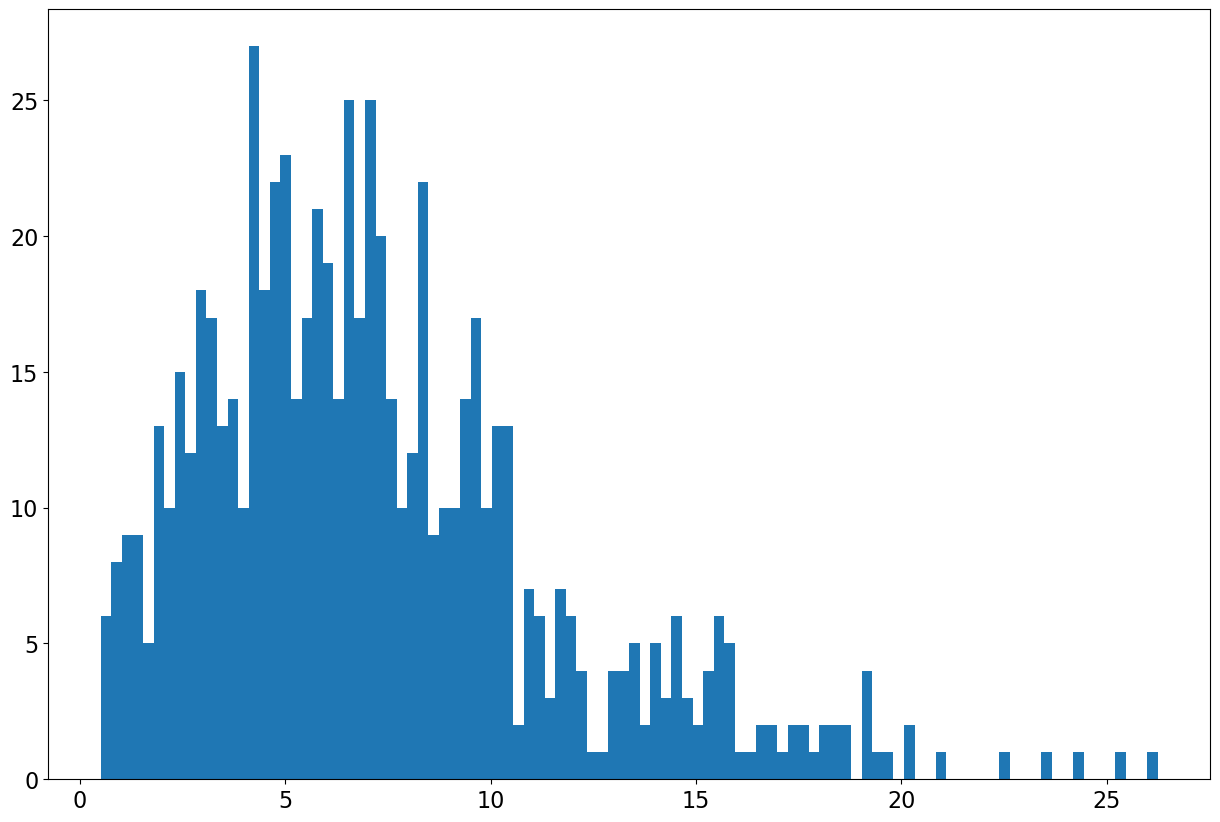

In [12]:
plt.hist(d.vws_pmd, bins=100)

### 1) By basin

/tmp/ipykernel_22798/1050194481.py:237: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_22798/1050194481.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


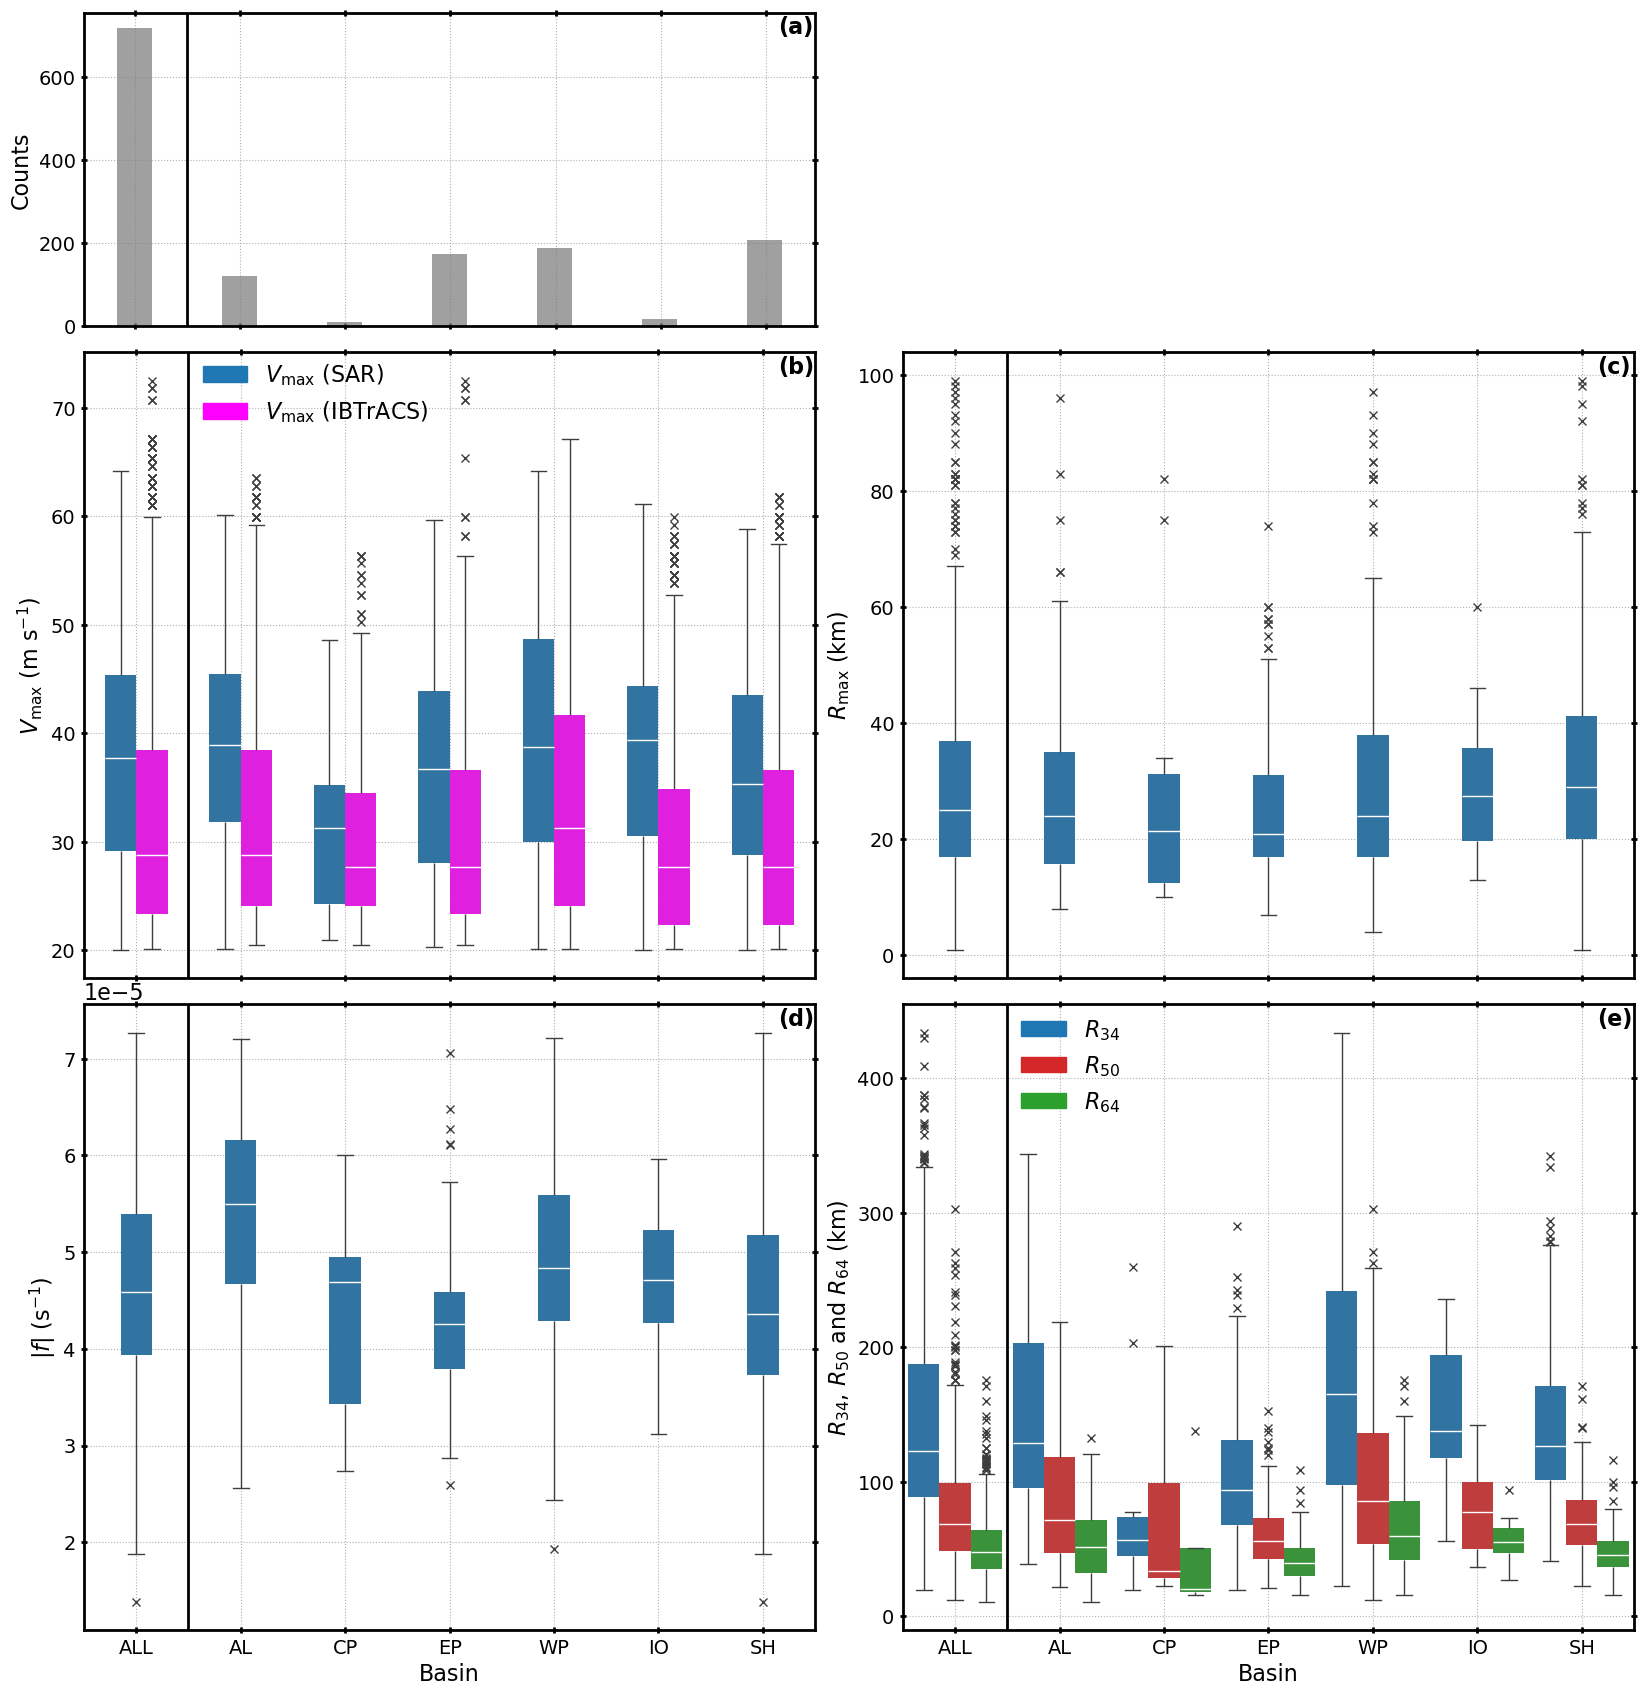

In [21]:
# Hyperparameters
width      = 0.3
bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 21))
gs         = GridSpec(3, 2, hspace=0.05, wspace=0.12, height_ratios=[1, 2, 2])

##############
### COUNTS ###
##############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.935, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])

# Boxplot
g = sns.histplot(
    data=df_combined,
    x='basin_idx',
    bins=bins,
    color='grey',
    edgecolor=None,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'Counts')
# ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### VMAX ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'vmx': color_glob}

### Version with IBTrACS
# Reshape the 'vmx_reg' data from dsi into a pandas DataFrame
df_vmx_reg = dsi_stacked[['basin_idx', 'vmx_reg']].drop_vars(names=['time', 'lon', 'lat', 'idx', 'storm', 'date_time']).to_dataframe().reset_index()
df_vmx_reg = df_vmx_reg.melt(id_vars='basin_idx', value_vars=['vmx_reg'])
df_vmx_reg = df_vmx_reg.rename(columns={'vmx_reg': 'value'})
# Add global
df_vmx_reg_global              = df_vmx_reg.copy()
df_vmx_reg_global['basin_idx'] = 0
df_vmx_reg                     = pd.concat([df_vmx_reg, df_vmx_reg_global])
# Combine the new data with the existing data
df_combined = pd.concat([df_combined, df_vmx_reg], ignore_index=True)
# New color palette to include 'vmx' and 'vmx_reg'
palette = {
    'vmx':      color_glob, # Use your specific color for vmx (e.g., color_glob)
    'vmx_reg': 'magenta'    # Choose a new color for the new variable
}
########################

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    # width=width,
    width=width * 2
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

### Version with IBTrACS (also uncomment ax.legend_.remove())
# Legend
handle_vmx = mpatches.Patch(color=color_glob, label='VMX')
handle_vmx_reg = mpatches.Patch(color='magenta', label='VMX_reg')
legend_handles = [handle_vmx, handle_vmx_reg]
legend_labels = [r'$V_{\text{max}}$ (SAR)', r'$V_{\text{max}}$ (IBTrACS)']
ax.legend(handles=legend_handles, labels=legend_labels, frameon=False, loc=(0.15, 0.87))
########################

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$V_{\text{max}}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### RMAX ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rmx'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'rmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$R_{\text{max}}$ (km)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### FCOR ###
############
ax = fig.add_subplot(gs[2, 0])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'fcor']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['fcor'])
df_plot['value']       = abs(df_plot['value'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'fcor': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$|f|$ (s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[2, 1])
ax.text(0.95, 0.965, '(e)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'r34', 'r50', 'r64']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['r34', 'r50', 'r64'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r34': color_glob, 
    'r50': color_r50,
    'r64': color_r64,
}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Legend
handle_r34 = mpatches.Patch(color=color_glob, label='r34')
handle_r50 = mpatches.Patch(color=color_r50,  label='r50')
handle_r64 = mpatches.Patch(color=color_r64,  label='r64')
legend_handles = [handle_r34, handle_r50, handle_r64]
legend_labels = [r'$R_{\text{34}}$', r'$R_{\text{50}}$', r'$R_{\text{64}}$']
ax.legend(handles=legend_handles, labels=legend_labels, frameon=False, loc=(0.15, 0.81))

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{\text{34}}$, $R_{\text{50}}$ and $R_{\text{64}}$ (km)')
# ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'best_track_prms_by_basin.png', bbox_inches='tight')

/tmp/ipykernel_22798/3889426428.py:160: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_22798/3889426428.py:220: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


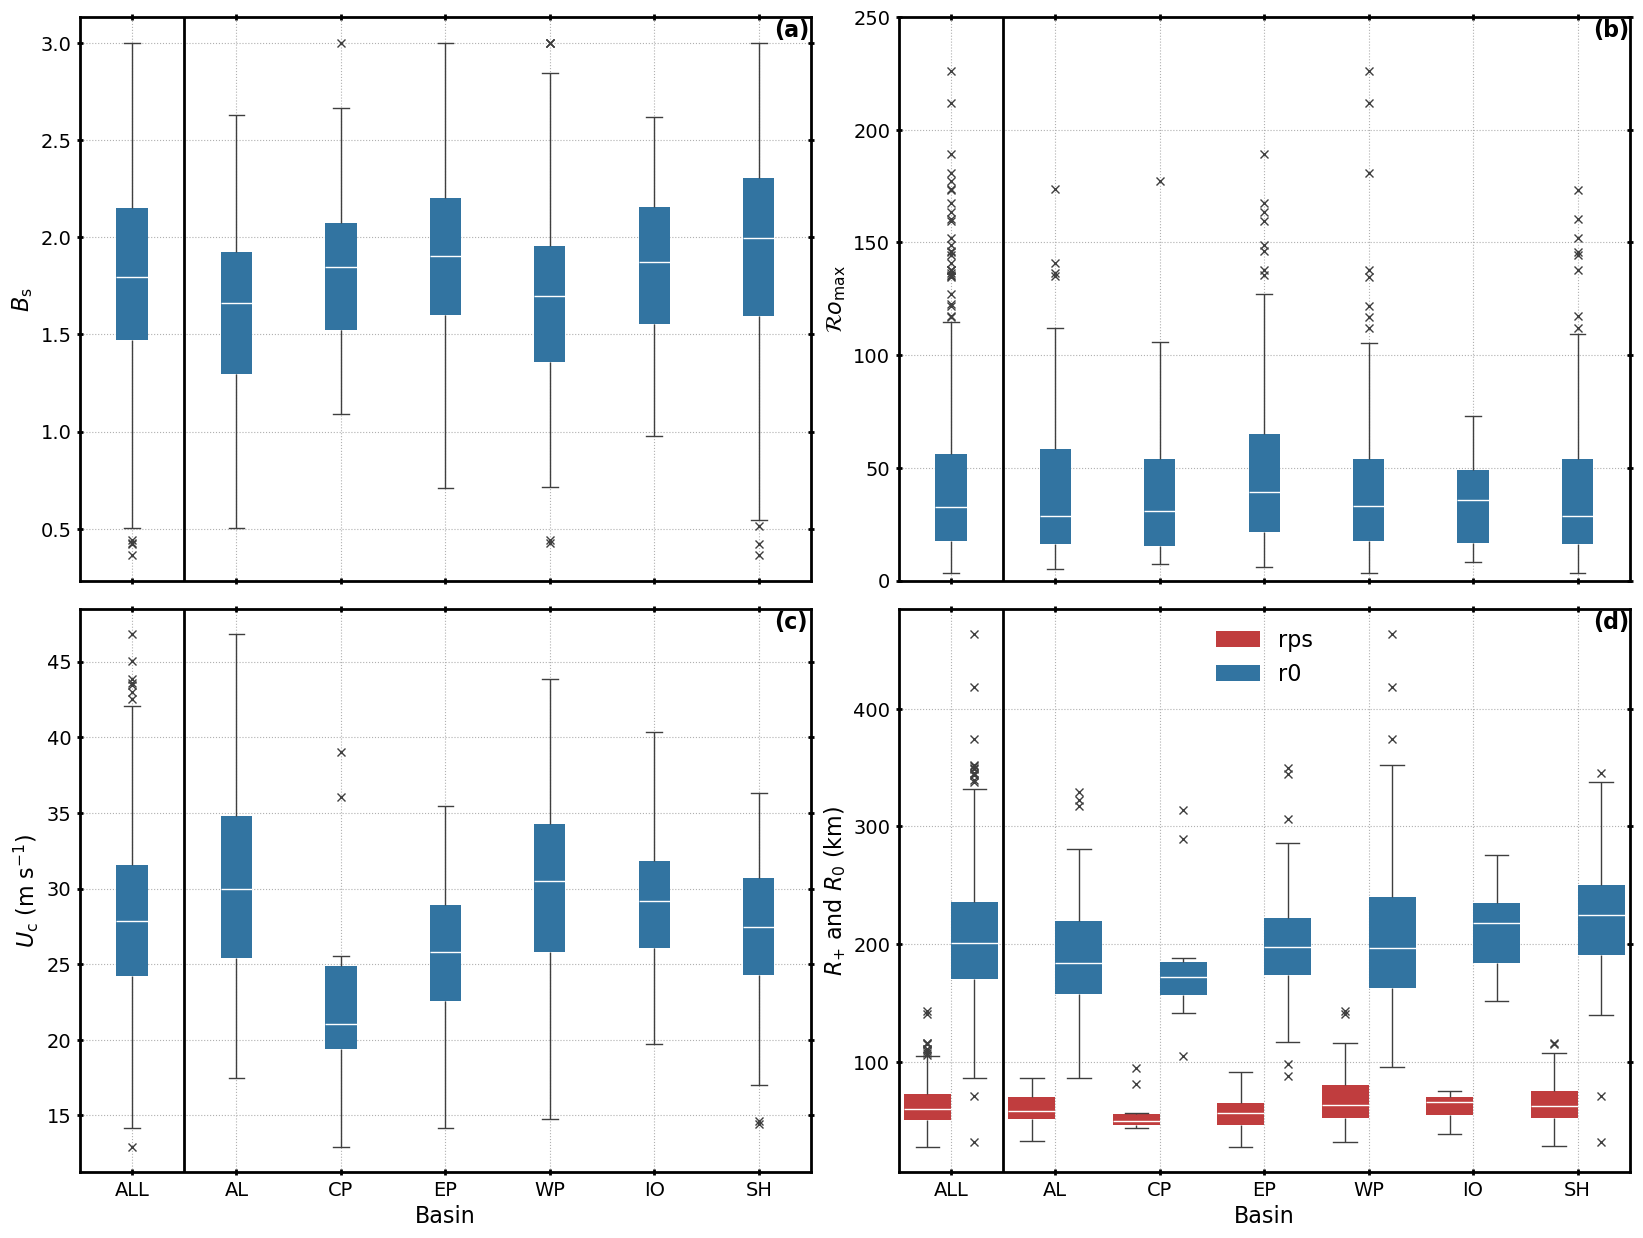

In [22]:
# Hyperparameters
width      = 0.3
bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 15))
gs         = GridSpec(2, 2, hspace=0.05, wspace=0.12, height_ratios=[2, 2])

############
###  Bs  ###
############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.965, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'B_hol']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['B_hol'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'B_hol': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$B_{\text{s}}$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rsby ###
############
ax = fig.add_subplot(gs[0, 1])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rsby']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rsby'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'rsby': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$\mathcal{R}o_{\text{max}}$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

ax.set_ylim(0, 250)

############
###  Uc  ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'uc']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['uc'])
df_plot['value']       = abs(df_plot['value'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'uc': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rps', 'r0']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rps', 'r0'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r0':  color_glob, 
    'rps': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{\text{+}}$ and $R_{\text{0}}$ (km)')
ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'dynamical_prms_by_basin.png', bbox_inches='tight')

In [15]:
print('Vmax = {:.1f} m/s'.format(d.vmx.median()))
print('Rmax = {:.1f} km'.format(d.rmx.median() / 1000))
print('|f|  = {:.1f}e-5 s-1'.format(abs(d.fcor.median()) * 1e5))
print('R34 = {:.1f} km'.format(d.r34.median() / 1000))
print('R50 = {:.1f} km'.format(d.r50.median() / 1000))
print('R64 = {:.1f} km'.format(d.r64.median() / 1000))
print('')
print('B_hol = {:.1f}'.format(d.B_hol.median()))
print('Romax = {:.1f}'.format(d.rsby.median()))
print('Uc = {:.1f} m/s'.format(d.uc.median()))
print('R0 = {:.1f} km'.format(d.r0.median() / 1000))
print('R+ = {:.1f} km'.format(d.rps.median() / 1000))

Vmax = 37.7 m/s
Rmax = 25.0 km
|f|  = 4.2e-5 s-1
R34 = 123.0 km
R50 = 69.0 km
R64 = 48.0 km

B_hol = 1.8
Romax = 32.6
Uc = 27.8 m/s
R0 = 201.1 km
R+ = 60.0 km


In [16]:
print('Vmax IBTrACS = {:.1f} m/s'.format(dsi_stacked.vmx_reg.median()))

Vmax IBTrACS = 28.8 m/s


### 2) By time

In [27]:
### Assign time group for SAR
# Choose time reference
nb_of_days  = 3
delta_t     = 1 # 1 for 12 hours, 2 for 24 hours, etc...
tLMI_bins   = np.linspace(-24 * nb_of_days - delta_t * 6, 24 * nb_of_days + delta_t * 6, int(4 / delta_t) * nb_of_days + 2)
tLMI_labels = np.linspace(-24 * nb_of_days, 24 * nb_of_days, int(4 / delta_t) * nb_of_days + 1)
print(tLMI_bins)
print(tLMI_labels)

# Initialize
l_tLMI_labels = []

# Assign label iteratively
for t in tqdm(range(len(d.time))):
    notInAnyBin = True
    for k in range(len(tLMI_bins) - 1):
        if (d.isel(time=t).t_since_lmi_ibt / 3600 >= tLMI_bins[k]) and (d.isel(time=t).t_since_lmi_ibt / 3600 <= tLMI_bins[k + 1]):
            l_tLMI_labels.append(float(tLMI_labels[k]))
            notInAnyBin = False
    if notInAnyBin:
        l_tLMI_labels.append(np.nan)

# Assign output list
d['tLMI_lab'] = xr.DataArray(l_tLMI_labels, d.coords)

# Choose basin
db         = d.where(d.basin == 'ep', drop=True).dropna(dim='time', subset=['tLMI_lab']) # d_basin, # Update the plots which are currently set to 'al'
print(len(db.time))

[-78. -66. -54. -42. -30. -18.  -6.   6.  18.  30.  42.  54.  66.  78.]
[-72. -60. -48. -36. -24. -12.   0.  12.  24.  36.  48.  60.  72.]


  0%|          | 0/718 [00:00<?, ?it/s]

149


In [28]:
### Assign time group for IBTrACS
# Initialize
l_tLMI_labels = []

print(len(l_tLMI_labels))

# Assign label iteratively
for i in tqdm(range(len(dsi_stacked.idx))):
    notInAnyBin = True
    for k in range(len(tLMI_bins) - 1):
        if (dsi_stacked.isel(idx=i).t_since_lmi / 3600 >= tLMI_bins[k]) and (dsi_stacked.isel(idx=i).t_since_lmi / 3600 < tLMI_bins[k + 1]):
            l_tLMI_labels.append(float(tLMI_labels[k]))
            notInAnyBin = False
    if notInAnyBin:
        l_tLMI_labels.append(np.nan)

print(len(l_tLMI_labels))

dsi_stacked['tLMI_lab'] = xr.DataArray(l_tLMI_labels, dsi_stacked.coords)

# Choose basin
dsi_stackedb = dsi_stacked.where(dsi_stacked.basin == 'EP', drop=True).dropna(dim='idx', subset=['tLMI_lab']) # d_basin
print(len(dsi_stackedb.time))

0


  0%|          | 0/27487 [00:00<?, ?it/s]

27487
4995


/tmp/ipykernel_22798/129717714.py:218: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_22798/129717714.py:281: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


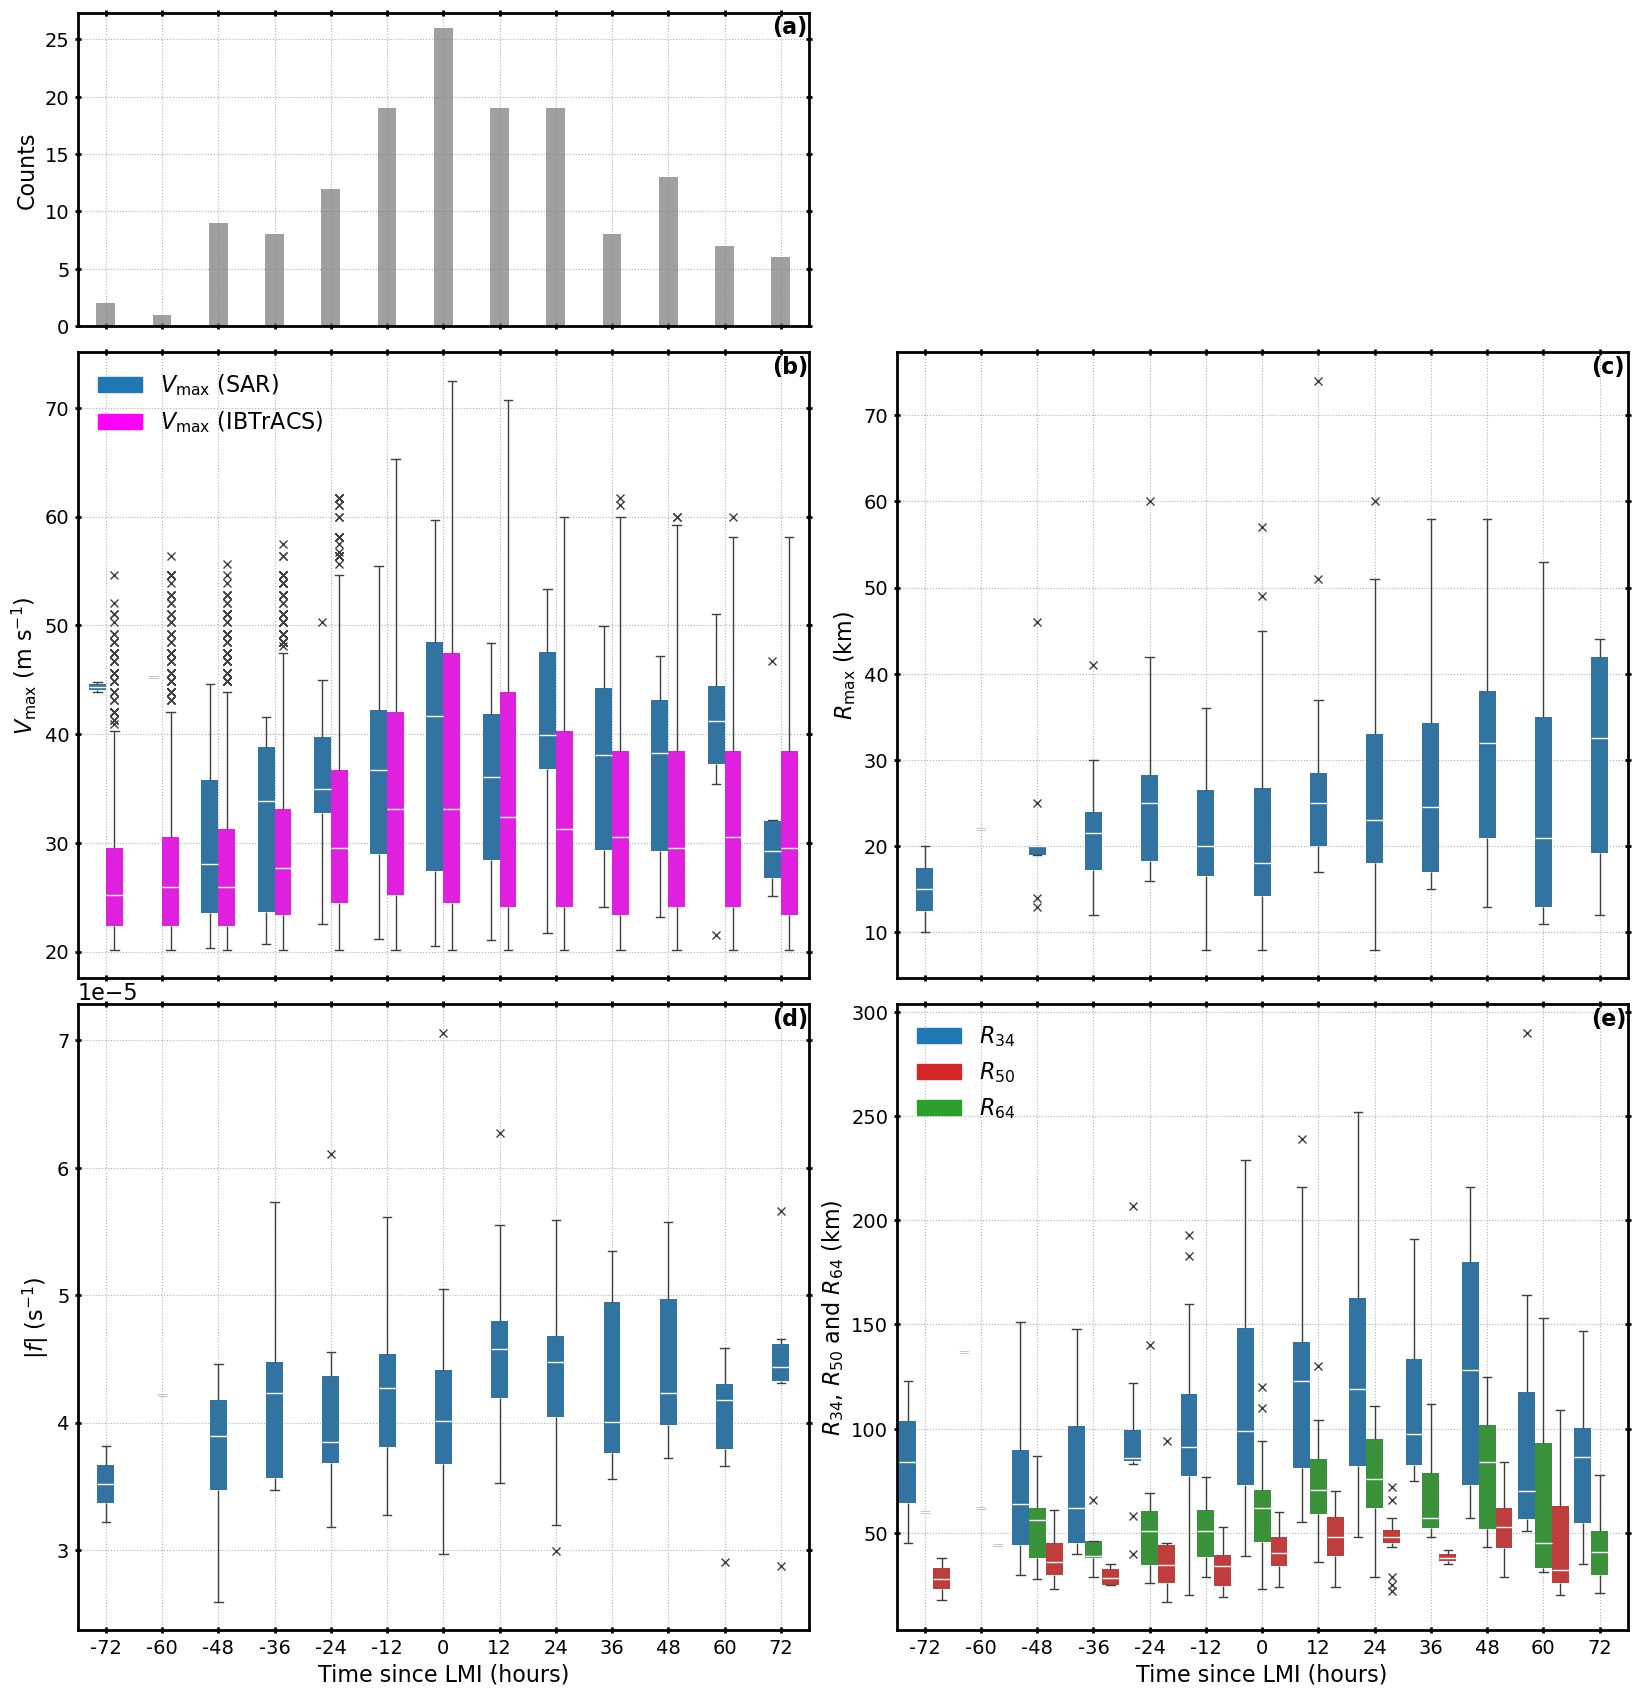

In [32]:
# Hyperparameters
width      = 0.3
width_bis  = 4
bins       = np.arange(-24 * nb_of_days - width_bis / 2, 24 * nb_of_days + width_bis / 2 + (tLMI_bins[1] - tLMI_bins[0]), width_bis)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 21))
gs         = GridSpec(3, 2, hspace=0.05, wspace=0.12, height_ratios=[1, 2, 2])

##############
### COUNTS ###
##############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.935, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['vmx'])
df_global              = df_plot.copy()
# df_global['tLMI_lab']  = 0
df_combined            = pd.concat([df_plot, df_global])

# Boxplot
g = sns.histplot(
    data=df_plot,
    x='tLMI_lab',
    bins=bins,
    color='grey',
    edgecolor=None,
)

# Labels
# xlabels = [int(l) for l in tLMI_labels]
ax.set_xticks(tLMI_labels)
ax.set_xlim(-24 * nb_of_days - 6, 24 * nb_of_days + 6)
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'Counts')
# ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### VMAX ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['vmx'])
# Colors
palette                = {'vmx': color_glob}

### Version with IBTrACS
# Reshape the 'vmx_reg' data from dsi into a pandas DataFrame
df_vmx_reg = dsi_stacked[['tLMI_lab', 'vmx_reg']].drop_vars(names=['time', 'lon', 'lat', 'idx', 'storm', 'date_time']).to_dataframe().reset_index()
df_vmx_reg = df_vmx_reg.melt(id_vars='tLMI_lab', value_vars=['vmx_reg'])
df_vmx_reg = df_vmx_reg.rename(columns={'vmx_reg': 'value'})
# Combine the new data with the existing data
df_plot    = pd.concat([df_plot, df_vmx_reg], ignore_index=True)
# New color palette to include 'vmx' and 'vmx_reg'
palette = {
    'vmx':      color_glob, # Use your specific color for vmx (e.g., color_glob)
    'vmx_reg': 'magenta'    # Choose a new color for the new variable
}
########################

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    # width=width,
    width=width * 2,
)

### Version with IBTrACS (also uncomment ax.legend_.remove())
# Legend
handle_vmx = mpatches.Patch(color=color_glob, label='VMX')
handle_vmx_reg = mpatches.Patch(color='magenta', label='VMX_reg')
legend_handles = [handle_vmx, handle_vmx_reg]
legend_labels = [r'$V_{\text{max}}$ (SAR)', r'$V_{\text{max}}$ (IBTrACS)']
ax.legend(handles=legend_handles, labels=legend_labels, frameon=False, loc='upper left')
########################

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$V_{\text{max}}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# Test
boxplot_xlim = plt.xlim()

############
### RMAX ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'rmx']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['rmx'])
df_plot['value']       = df_plot['value'] / 1000
# Colors
palette                = {'rmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$R_{\text{max}}$ (km)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### FCOR ###
############
ax = fig.add_subplot(gs[2, 0])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'fcor']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['fcor'])
df_plot['value']       = abs(df_plot['value'])
# Colors
palette                = {'fcor': color_glob}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Labels
xlabels = [int(l) for l in tLMI_labels]
g.set_xticklabels(xlabels)
g.set_xlabel('Time since LMI (hours)')
g.set_ylabel(r'$|f|$ (s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[2, 1])
ax.text(0.95, 0.965, '(e)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'r34', 'r50', 'r64']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['r34', 'r50', 'r64'])
df_plot['value']       = df_plot['value'] / 1000
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r34': color_glob, 
    'r50': 'tab:green',
    'r64': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Legend
handle_r34 = mpatches.Patch(color=color_glob, label='r34')
handle_r50 = mpatches.Patch(color=color_r50,  label='r50')
handle_r64 = mpatches.Patch(color=color_r64,  label='r64')
legend_handles = [handle_r34, handle_r50, handle_r64]
legend_labels = [r'$R_{\text{34}}$', r'$R_{\text{50}}$', r'$R_{\text{64}}$']
ax.legend(handles=legend_handles, labels=legend_labels, frameon=False, loc='upper left')

# Labels
xlabels = [int(l) for l in tLMI_labels]
g.set_xticklabels(xlabels)
g.set_xlabel('Time since LMI (hours)')
g.set_ylabel(r'$R_{\text{34}}$, $R_{\text{50}}$ and $R_{\text{64}}$ (km)')
# ax.legend(frameon=False, loc='upper left')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'best_track_prms_by_time_for_one_basin.png', bbox_inches='tight')

/tmp/ipykernel_22798/1765098714.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_22798/1765098714.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


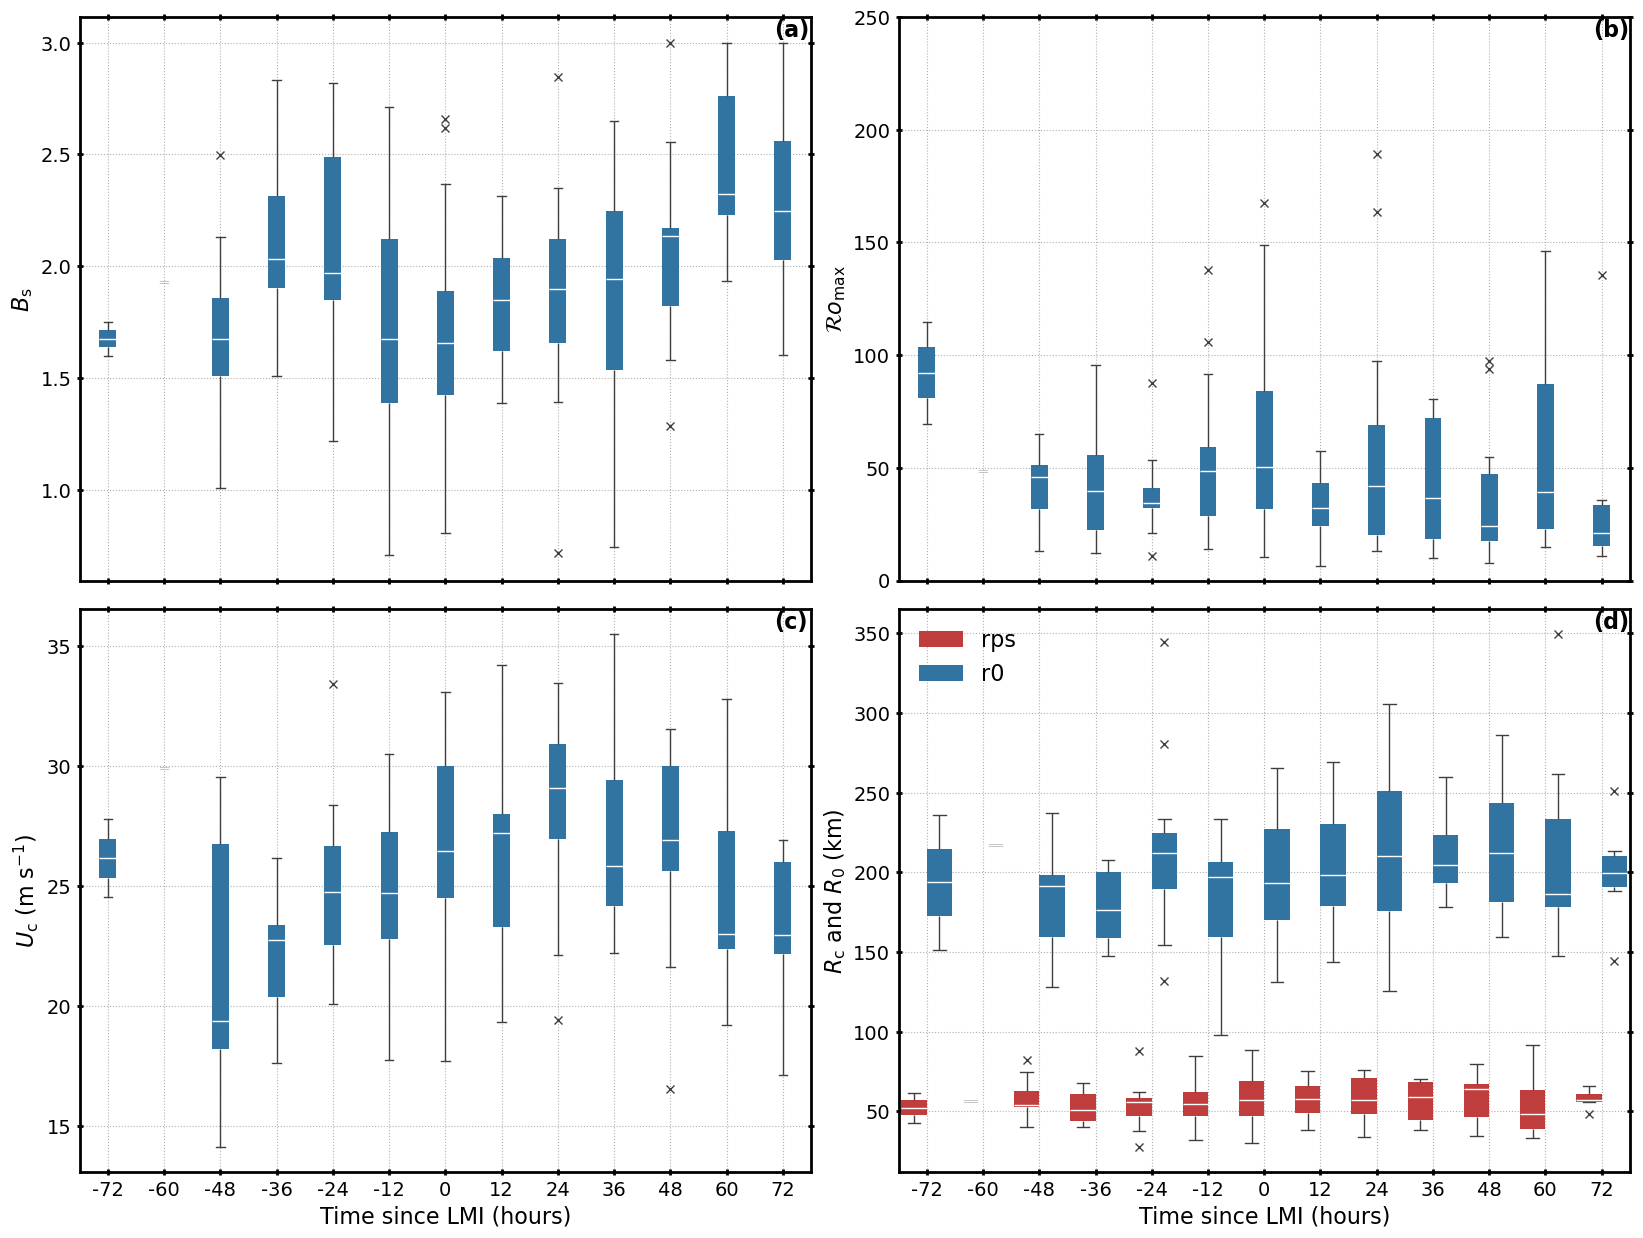

In [34]:
# Hyperparameters
width      = 0.3
# bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
bins='auto'
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 15))
gs         = GridSpec(2, 2, hspace=0.05, wspace=0.12, height_ratios=[2, 2])

############
###  Bs  ###
############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.965, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'B_hol']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['B_hol'])
# Colors
palette                = {'B_hol': color_glob}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$B_{\text{s}}$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rsby ###
############
ax = fig.add_subplot(gs[0, 1])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'rsby']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['rsby'])
# Colors
palette                = {'rsby': color_glob}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$\mathcal{R}o_{\text{max}}$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

ax.set_ylim(0, 250)

############
###  Uc  ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'uc']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['uc'])
df_plot['value']       = abs(df_plot['value'])
# Colors
palette                = {'uc': color_glob}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Labels
xlabels = [int(l) for l in tLMI_labels]
g.set_xticklabels(xlabels)
g.set_xlabel('Time since LMI (hours)')
g.set_ylabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = db[['tLMI_lab', 'rps', 'r0']].to_dataframe()
df_plot                = df.melt(id_vars='tLMI_lab', value_vars=['rps', 'r0'])
df_plot['value']       = df_plot['value'] / 1000
# Colors
palette = {
    'r0':  color_glob, 
    'rps': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='tLMI_lab', 
    y='value', 
    hue='variable', 
    data=df_plot, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Labels
xlabels = [int(l) for l in tLMI_labels]
g.set_xticklabels(xlabels)
g.set_xlabel('Time since LMI (hours)')
g.set_ylabel(r'$R_{\text{c}}$ and $R_{\text{0}}$ (km)')
ax.legend(frameon=False, loc='upper left')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'dynamical_prms_by_time_for_one_basin.png', bbox_inches='tight')

### 3) Wind profile evolution

On est finalement assez proche de 

v_star = 2 * r_star^-1.5 * exp(-r_star^-2)

ou encore

v_star = r_star^1.5 * frechet(r_star, 2, 1)

In [14]:
from scipy.stats import gamma
from scipy.stats import gennorm

### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def frechet(x, alpha, s, m=0):
    return (alpha / s) * ((x - m) / s) ** (-1 - alpha) * np.exp(-((x - m) / s) ** (-alpha))

def modified_rankine(x, alpha, vmn=0.3):
    V = np.ones_like(xs)
    V[x < 1]  = vmn + (1 - vmn) * x[x <  1]
    V[x >= 1] = vmn + (1 - vmn) * (1 / x[x >=  1]) ** alpha
    return V

# def holland_star(x, B, vmn=0.3):
#     '''Cyclostrophic version.'''
#     return vmn + (1 - vmn) * np.sqrt(((1 / x) ** B) * np.exp(1 - (1 / x) ** B))

def holland_star(x, B, vmn=0.3):
    '''Divide Eq. 7 of the MWR 2023 paper by Vmax to understand what's happening.
    The constant is then necessarily equal to f * Rmax / (2 * Vmax).
    '''
    # c = 0.01679847129304227
    c = 0.017
    return vmn + (1 - vmn) * np.sqrt(((1 / x) ** B) * np.exp(1 - (1 / x) ** B) + (x * c) ** 2) - x * c

print(float(abs(d.fcor).mean() * d.rmx.mean() / (2 * d.vmx.mean())))

print(float(d.B_hol.mean(skipna=True)))

### REFERENCE GRID
rs = np.linspace(0, 500000, 50001) # define dr accordingly
xs = np.linspace(0, 20, 1000)

0.01679847129304227
1.844014276345084


#### Regular coordinates

In [13]:
# [-78. -66. -54. -42. -30. -18.  -6.   6.  18.  30.  42.  54.  66.  78.]
# [-72. -60. -48. -36. -24. -12.   0.  12.  24.  36.  48.  60.  72.]

In [14]:
initializing = db.where(db.tLMI_lab <= -24, drop=True) # play with it, change 24 to 36 and vice versa :)
intensifying = db.where((db.tLMI_lab > -24) & (db.tLMI_lab <= 0),  drop=True) # same here
____maturing = db.where((db.tLMI_lab > 0)   & (db.tLMI_lab <= 24), drop=True)
___weakening = db.where(db.tLMI_lab  > 24,  drop=True)
print('Intializing = {}\nIntensifying = {}\nMaturing = {}\nWeakening = {}'.format(len(initializing.time), len(intensifying.time), len(____maturing.time), len(___weakening.time)))

# With the mean
V_initializing = holland_profile(rs, float(initializing.lat.mean(dim='time', skipna=True)), float(initializing.B_hol.mean(dim='time', skipna=True)), float(initializing.vmn_hol.mean(dim='time', skipna=True)), float(initializing.rmx_hol.mean(dim='time', skipna=True)), float(initializing.vmx_hol.mean(dim='time', skipna=True)))
V_intensifying = holland_profile(rs, float(intensifying.lat.mean(dim='time', skipna=True)), float(intensifying.B_hol.mean(dim='time', skipna=True)), float(intensifying.vmn_hol.mean(dim='time', skipna=True)), float(intensifying.rmx_hol.mean(dim='time', skipna=True)), float(intensifying.vmx_hol.mean(dim='time', skipna=True)))
V_____maturing = holland_profile(rs, float(____maturing.lat.mean(dim='time', skipna=True)), float(____maturing.B_hol.mean(dim='time', skipna=True)), float(____maturing.vmn_hol.mean(dim='time', skipna=True)), float(____maturing.rmx_hol.mean(dim='time', skipna=True)), float(____maturing.vmx_hol.mean(dim='time', skipna=True)))
V____weakening = holland_profile(rs, float(___weakening.lat.mean(dim='time', skipna=True)), float(___weakening.B_hol.mean(dim='time', skipna=True)), float(___weakening.vmn_hol.mean(dim='time', skipna=True)), float(___weakening.rmx_hol.mean(dim='time', skipna=True)), float(___weakening.vmx_hol.mean(dim='time', skipna=True)))
lVs            = [V_initializing, V_intensifying, V_____maturing, V____weakening]

Intializing = 27
Intensifying = 35
Maturing = 31
Weakening = 27


In [15]:
# # With the median
# V_initializing = holland_profile(rs, float(initializing.lat.median(dim='time', skipna=True)), float(initializing.B_hol.median(dim='time', skipna=True)), float(initializing.vmn_hol.median(dim='time', skipna=True)), float(initializing.rmx_hol.median(dim='time', skipna=True)), float(initializing.vmx_hol.median(dim='time', skipna=True)))
# V_intensifying = holland_profile(rs, float(intensifying.lat.median(dim='time', skipna=True)), float(intensifying.B_hol.median(dim='time', skipna=True)), float(intensifying.vmn_hol.median(dim='time', skipna=True)), float(intensifying.rmx_hol.median(dim='time', skipna=True)), float(intensifying.vmx_hol.median(dim='time', skipna=True)))
# V_____maturing = holland_profile(rs, float(____maturing.lat.median(dim='time', skipna=True)), float(____maturing.B_hol.median(dim='time', skipna=True)), float(____maturing.vmn_hol.median(dim='time', skipna=True)), float(____maturing.rmx_hol.median(dim='time', skipna=True)), float(____maturing.vmx_hol.median(dim='time', skipna=True)))
# V____weakening = holland_profile(rs, float(___weakening.lat.median(dim='time', skipna=True)), float(___weakening.B_hol.median(dim='time', skipna=True)), float(___weakening.vmn_hol.median(dim='time', skipna=True)), float(___weakening.rmx_hol.median(dim='time', skipna=True)), float(___weakening.vmx_hol.median(dim='time', skipna=True)))
# lVs            = [V_initializing, V_intensifying, V_____maturing, V____weakening]

In [16]:
from matplotlib.colors import LinearSegmentedColormap
# colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered')] # first color is black, last is red
colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered'), mpl.colors.to_rgb('royalblue')] # first color is black, last is red
cm     = LinearSegmentedColormap.from_list("Custom", colors, N=20)

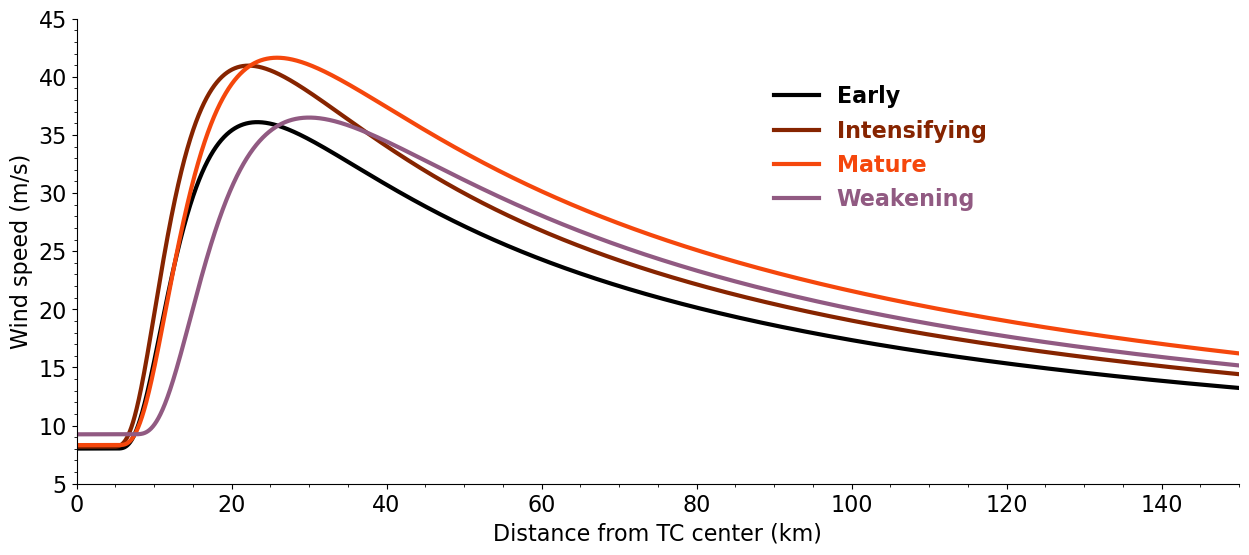

In [17]:
fig        = plt.figure(figsize=(15, 10))
gs         = GridSpec(1, 1, hspace=0.18, wspace=0.02)

normalizer = Normalize(0, 80)
ax_lims2D  = 250

labels     = ['Early', 'Intensifying', 'Mature', 'Weakening']

############
# PROFILES #
############
ax = fig.add_subplot(gs[0, 0])
# ax.set_title('d', weight='bold', loc='left')

for k, Vh in enumerate(lVs):
    ax.plot(rs / 1000, Vh, c=cm(k / len(lVs)), linewidth=3, label=labels[k])

ax.set_xlim(0, 150);ax.set_ylim(5, 45)
ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Wind speed (m/s)')
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.8, 0.9), prop=dict(weight='bold'))

# plt.savefig(PTHS['sav_dir'] + 'wind_profile_evolution.png', bbox_inches='tight')

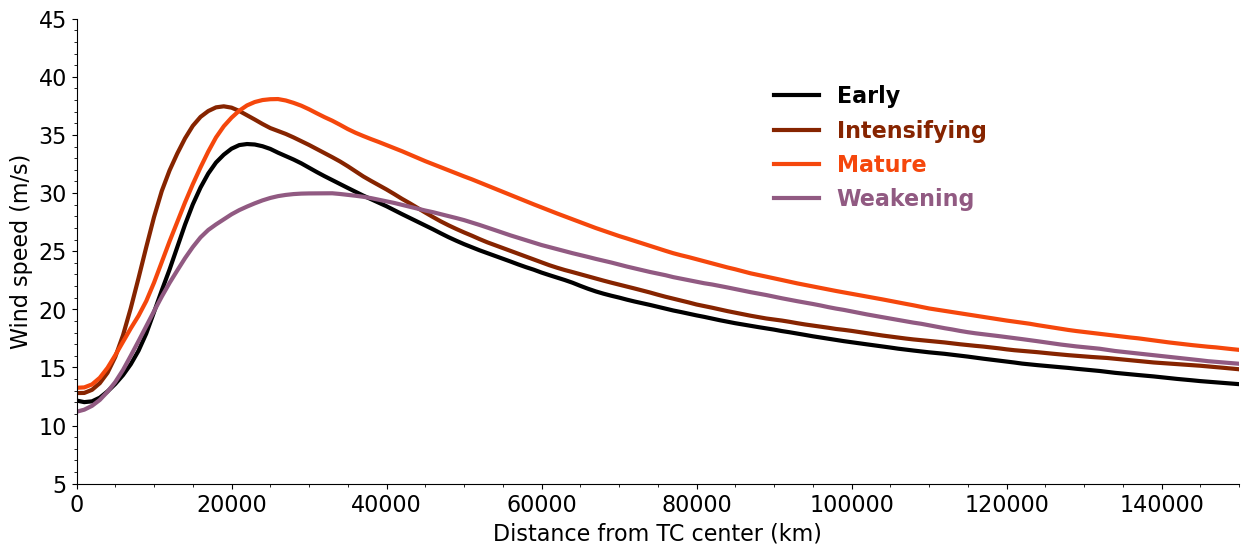

In [18]:
fig        = plt.figure(figsize=(15, 10))
gs         = GridSpec(1, 1, hspace=0.18, wspace=0.02)

normalizer = Normalize(0, 80)

labels     = ['Early', 'Intensifying', 'Mature', 'Weakening']

############
# PROFILES #
############
ax = fig.add_subplot(gs[0, 0])
# ax.set_title('d', weight='bold', loc='left')

for k, db_sub in enumerate([initializing, intensifying, ____maturing, ___weakening]):
    db_sub_ws = xr.open_mfdataset(list(np.array(PTHS['sar_dir'] + db_sub.file_tcva)))
    # Append wind profile
    db_sub_ws.mean(dim=['theta', 'time']).wind_speed.plot(c=cm(k / len(lVs)), linewidth=3, label=labels[k])
    # Close
    db_sub_ws.close()

ax.set_xlim(0, 150 * 1000);ax.set_ylim(5, 45)
ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Wind speed (m/s)')
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.8, 0.9), prop=dict(weight='bold'))

# plt.savefig(PTHS['sav_dir'] + 'wind_profile_evolution.png', bbox_inches='tight')

#### Normalized coordinates

In [49]:
rs2 = np.linspace(0, 500000, 501)
def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / (r + 0.000001)) * np.gradient(r * v, dr)

In [62]:
### With (V*, r*) and real data (not Holland)

# Reference grid
# r_star = np.linspace(0, 8, 150)
r_star = np.linspace(0, 15, 150)

# Instantiate list
VSTARS = []
ZSTARS = []

for t in tqdm(range(len(d.time))):
    # Open wind speed
    ws = xr.open_dataset(PTHS['sar_dir'] + d.isel(time=t).file_tcva.item()).isel(time=0).wind_speed.mean(dim='theta')

    # Interpolate and append
    # VSTARS.append(np.interp(r_star, np.array(ws.rad) / float(d.isel(time=t).rmx), np.array(ws)))
    VSTARS.append(np.interp(r_star, np.array(ws.rad) / float(d.isel(time=t).rmx), np.array(ws) / float(d.isel(time=t).vmx)))
    # VSTARS.append(np.interp(r_star, np.array(ws.rad) / float(d.isel(time=t).r34), np.array(ws)))
    # VSTARS.append(np.interp(r_star, np.array(ws.rad) / float(d.isel(time=t).r34), np.array(ws) / float(d.isel(time=t).vmx)))

    # Vorticity
    Vh     = holland_profile(rs2, float(abs(d.isel(time=t).lat)), float(d.isel(time=t).B_hol), float(d.isel(time=t).vmn_hol), float(d.isel(time=t).rmx_hol), float(d.isel(time=t).vmx_hol))
    zeta   = vorticity(rs2, Vh)
    zeta_m = zeta[rs2 >= float(d.isel(time=t).rmx)][0]
    ZSTARS.append(np.interp(r_star, rs2 / float(d.isel(time=t).rmx), zeta / zeta_m))
    
    # Close dataset
    ws.close()

  0%|          | 0/640 [00:00<?, ?it/s]

In [63]:
# Concatenate into a single dataset
dstar = xr.Dataset(
    data_vars={
        'v_star':       (('time', 'r_star'), VSTARS),
        'z_star':       (('time', 'r_star'), ZSTARS),
    },
    coords={
        'r_star': r_star,
        'time':   np.array(d.time)
    }
)

# Ancillary information
dstar['tLMI_lab']         = d.tLMI_lab.copy(deep=True)
dstar['basin']            = d.basin.copy(deep=True)
dstar['vmx_dot_smth_ibt'] = d.vmx_dot_smth_ibt.copy(deep=True)
dstar['rmx']              = d.rmx.copy(deep=True)

In [21]:
# Choose basin
# dbstar         = dstar.where(d.basin == 'ep', drop=True).dropna(dim='time', subset=['tLMI_lab']) # d_basin
dbstar           = dstar
print(len(dbstar.time))

# Separate phase
initializing = dbstar.where(dbstar.tLMI_lab <= -24, drop=True) # play with it, change 24 to 36 and vice versa :)
intensifying = dbstar.where((dbstar.tLMI_lab > -24) & (dbstar.tLMI_lab <= 0),  drop=True) # same here
____maturing = dbstar.where((dbstar.tLMI_lab > 0)   & (dbstar.tLMI_lab <= 24), drop=True)
___weakening = dbstar.where(dbstar.tLMI_lab  > 24,  drop=True)
print('Intializing = {}\nIntensifying = {}\nMaturing = {}\nWeakening = {}'.format(len(initializing.time), len(intensifying.time), len(____maturing.time), len(___weakening.time)))
l_Cats       = [initializing, intensifying, ____maturing, ___weakening]
# RI definition is 15.433 m/s in 24 hours
RI = dbstar.where(dbstar.vmx_dot_smth_ibt > 15.433 / 24, drop=True)
print('RIs = {}'.format(len(RI.time)))

# With the mean
V_initializing = np.array(initializing.v_star.mean(dim='time', skipna=True))
V_intensifying = np.array(intensifying.v_star.mean(dim='time', skipna=True))
V_____maturing = np.array(____maturing.v_star.mean(dim='time', skipna=True))
V____weakening = np.array(___weakening.v_star.mean(dim='time', skipna=True))
lVs            = [V_initializing, V_intensifying, V_____maturing, V____weakening]
V_RI           = np.array(RI.v_star.mean(dim='time', skipna=True))

640
Intializing = 173
Intensifying = 157
Maturing = 103
Weakening = 98
RIs = 105


/tmp/ipykernel_4309/167706122.py:22: RuntimeWarning: divide by zero encountered in power
  return (alpha / s) * ((x - m) / s) ** (-1 - alpha) * np.exp(-((x - m) / s) ** (-alpha))
/tmp/ipykernel_4309/167706122.py:22: RuntimeWarning: invalid value encountered in multiply
  return (alpha / s) * ((x - m) / s) ** (-1 - alpha) * np.exp(-((x - m) / s) ** (-alpha))
/tmp/ipykernel_4309/167706122.py:40: RuntimeWarning: divide by zero encountered in divide
  return vmn + (1 - vmn) * np.sqrt(((1 / x) ** B) * np.exp(1 - (1 / x) ** B) + (x * c) ** 2) - x * c
/tmp/ipykernel_4309/167706122.py:40: RuntimeWarning: invalid value encountered in multiply
  return vmn + (1 - vmn) * np.sqrt(((1 / x) ** B) * np.exp(1 - (1 / x) ** B) + (x * c) ** 2) - x * c


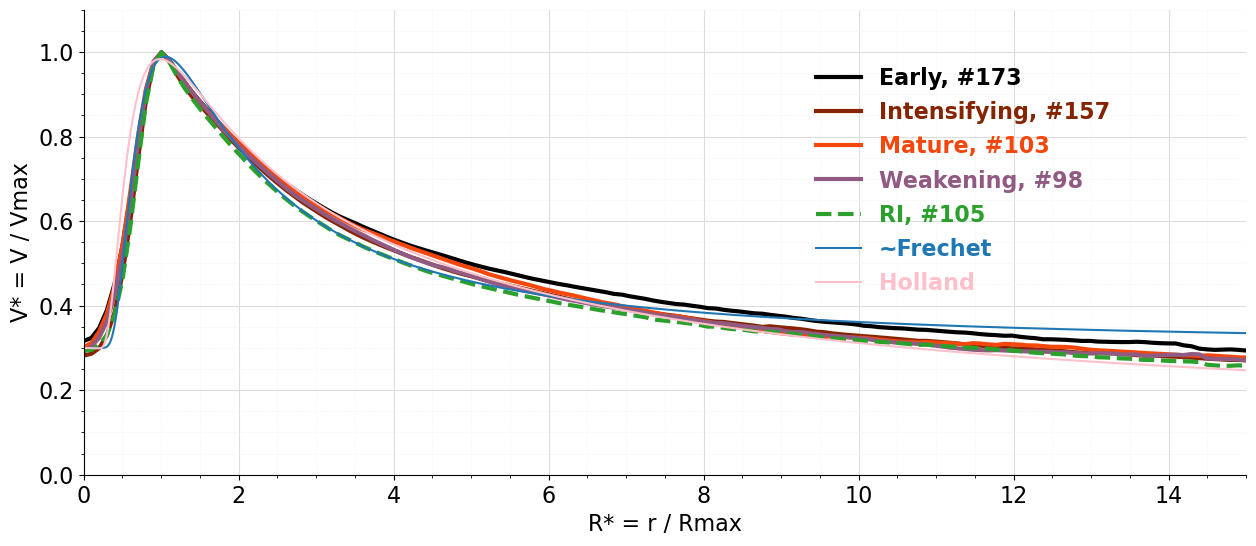

In [22]:
fig        = plt.figure(figsize=(15, 10))
gs         = GridSpec(1, 1, hspace=0.18, wspace=0.02)

normalizer = Normalize(0, 80)
ax_lims2D  = 250

labels     = ['Early', 'Intensifying', 'Mature', 'Weakening']

############
# PROFILES #
############
ax = fig.add_subplot(gs[0, 0])
# ax.set_title('d', weight='bold', loc='left')

# Profiles by phase
for k, Vh in enumerate(lVs):
    ax.plot(r_star, Vh, c=cm(k / len(lVs)), linewidth=3, label='{}, #{}'.format(labels[k], len(l_Cats[k].time)))
# RIs
ax.plot(r_star, V_RI, c='tab:green', linewidth=3, label='RI, #{}'.format(len(RI.time)), linestyle='dashed')

ax.set_xlim(0, 15);ax.set_ylim(0, 1.1)
ax.set_xlabel('R* = r / Rmax')
ax.set_ylabel('V* = V / Vmax')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.set_box_aspect(0.4)

# Test Frechet laws
# ax.plot(xs, 0.3 + frechet(xs, 2, 1.2))
# ax.plot(xs, 0.3 + frechet(xs, 1, 0.8, 0.6))
# ax.plot(xs, 0.3 + frechet(xs, 3, 1.7, -0.6))
# ax.plot(xs, 0.3 + frechet(xs, 10, 5.3, -4.3))

# ax.plot(xs, 0.3 + xs * frechet(xs, 1.9, 1.))
# ax.plot(xs, 0.3 + xs ** 2 * frechet(xs, 2.3, 0.75))

ax.plot(xs, 0.3 + xs ** 1.5 * frechet(xs, 1.9, 0.9), label='~Frechet')

# Rankine, Holland
# ax.plot(xs, modified_rankine(xs, 0.6), label='~Rankine, a=0.6')
# ax.plot(xs, modified_rankine(xs, 0.8), label='~Rankine, a=0.8')
plt.plot(xs, holland_star(xs, float(d.B_hol.mean(skipna=True)), vmn=0.3), label='Holland', c='pink')

# # Test Gamma laws
# plt.plot(xs, 0.3 + gamma.pdf(xs, 1.15, 0.8))
# plt.plot(xs, 0.3 + gennorm.pdf(xs, 2, 1, 0.8))
# plt.plot(xs, 0.3 + gennorm.pdf(xs, 1.5, 1, 0.8))

ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.9, 0.92), prop=dict(weight='bold'))

# plt.savefig(PTHS['sav_dir'] + 'universal_wind_profile.png', bbox_inches='tight')

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

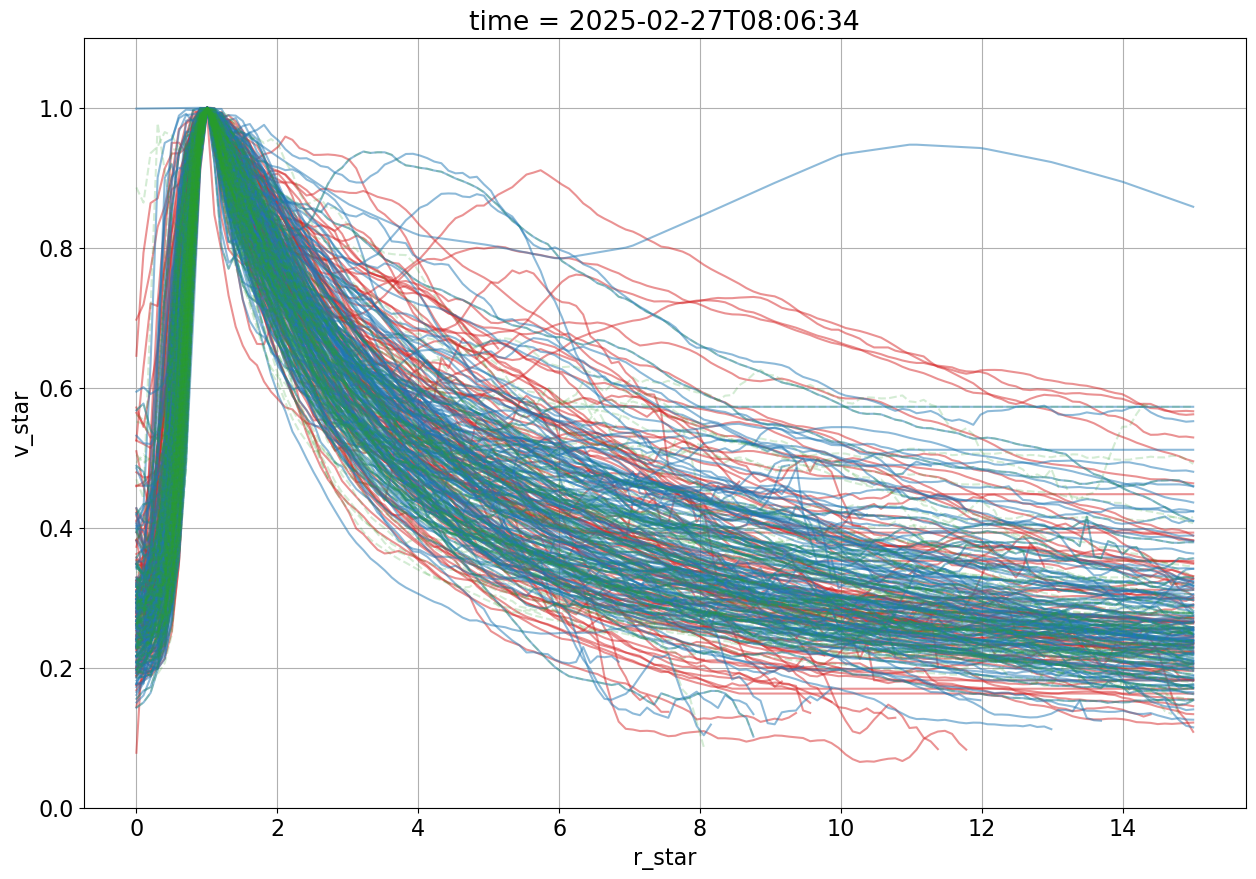

In [23]:
for t in tqdm(range(len(____maturing.time))):
    ____maturing.isel(time=t).v_star.plot(c='tab:red', alpha=0.5)

for t in tqdm(range(len(intensifying.time))):
    intensifying.isel(time=t).v_star.plot(c='tab:blue', alpha=0.5)

for t in tqdm(range(len(RI.time))):
    RI.isel(time=t).v_star.plot(c='tab:green', alpha=0.2, linestyle='dashed')

plt.ylim(0, 1.1)
plt.grid()

# plt.savefig(PTHS['sav_dir'] + 'individual_wind_profiles.png', bbox_inches='tight')

In [65]:
### Vorticity

# Choose basin
# dbstar         = dstar.where(d.basin == 'ep', drop=True).dropna(dim='time', subset=['tLMI_lab']) # d_basin
dbstar           = dstar
print(len(dbstar.time))

# Separate phase
initializing = dbstar.where(dbstar.tLMI_lab <= -24, drop=True) # play with it, change 24 to 36 and vice versa :)
intensifying = dbstar.where((dbstar.tLMI_lab > -24) & (dbstar.tLMI_lab <= 0),  drop=True) # same here
____maturing = dbstar.where((dbstar.tLMI_lab > 0)   & (dbstar.tLMI_lab <= 24), drop=True)
___weakening = dbstar.where(dbstar.tLMI_lab  > 24,  drop=True)
print('Intializing = {}\nIntensifying = {}\nMaturing = {}\nWeakening = {}'.format(len(initializing.time), len(intensifying.time), len(____maturing.time), len(___weakening.time)))
l_Cats       = [initializing, intensifying, ____maturing, ___weakening]
# RI definition is 15.433 m/s in 24 hours
RI = dbstar.where(dbstar.vmx_dot_smth_ibt > 15.433 / 24, drop=True)
print('RIs = {}'.format(len(RI.time)))

# With the mean
Z_initializing = np.array(initializing.z_star.mean(dim='time', skipna=True))
Z_intensifying = np.array(intensifying.z_star.mean(dim='time', skipna=True))
Z_____maturing = np.array(____maturing.z_star.mean(dim='time', skipna=True))
Z____weakening = np.array(___weakening.z_star.mean(dim='time', skipna=True))
lZs            = [Z_initializing, Z_intensifying, Z_____maturing, Z____weakening]
Z_RI           = np.array(RI.z_star.mean(dim='time', skipna=True))

640
Intializing = 173
Intensifying = 157
Maturing = 103
Weakening = 98
RIs = 105


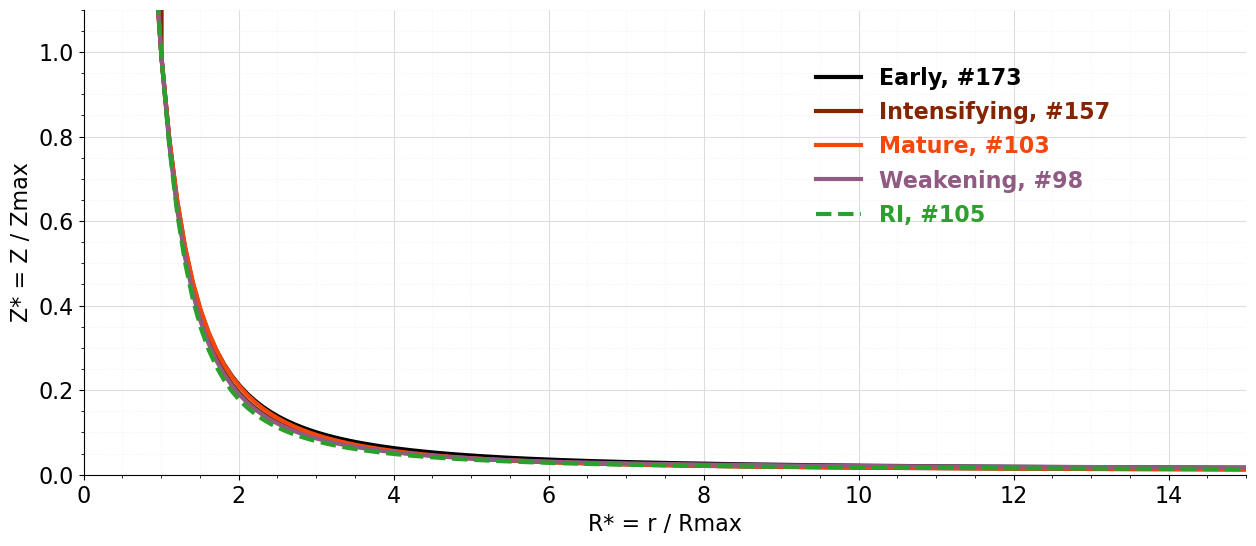

In [70]:
fig        = plt.figure(figsize=(15, 10))
gs         = GridSpec(1, 1, hspace=0.18, wspace=0.02)

normalizer = Normalize(0, 80)
ax_lims2D  = 250

labels     = ['Early', 'Intensifying', 'Mature', 'Weakening']

############
# PROFILES #
############
ax = fig.add_subplot(gs[0, 0])

# Profiles by phase
for k, Zh in enumerate(lZs):
    ax.plot(r_star, Zh, c=cm(k / len(lZs)), linewidth=3, label='{}, #{}'.format(labels[k], len(l_Cats[k].time)))
# RIs
ax.plot(r_star, Z_RI, c='tab:green', linewidth=3, label='RI, #{}'.format(len(RI.time)), linestyle='dashed')

ax.set_xlim(0, 15);ax.set_ylim(0, 1.1)
ax.set_xlabel('R* = r / Rmax')
ax.set_ylabel('Z* = Z / Zmax')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.set_box_aspect(0.4)

# ax.plot(xs, 0.3 + xs ** 1.5 * frechet(xs, 1.9, 0.9), label='~Frechet')
# plt.plot(xs, holland_star(xs, float(d.B_hol.mean(skipna=True)), vmn=0.3), label='Holland', c='pink')

ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.9, 0.92), prop=dict(weight='bold'))

# plt.savefig(PTHS['sav_dir'] + 'universal_vorticity.png', bbox_inches='tight')

### Fitting tests

In [24]:
from scipy.optimize import curve_fit

[1.87936906 1.3588616  0.31      ]


/tmp/ipykernel_4309/167706122.py:22: RuntimeWarning: divide by zero encountered in power
  return (alpha / s) * ((x - m) / s) ** (-1 - alpha) * np.exp(-((x - m) / s) ** (-alpha))
/tmp/ipykernel_4309/167706122.py:22: RuntimeWarning: invalid value encountered in multiply
  return (alpha / s) * ((x - m) / s) ** (-1 - alpha) * np.exp(-((x - m) / s) ** (-alpha))


(0.2, 1.05)

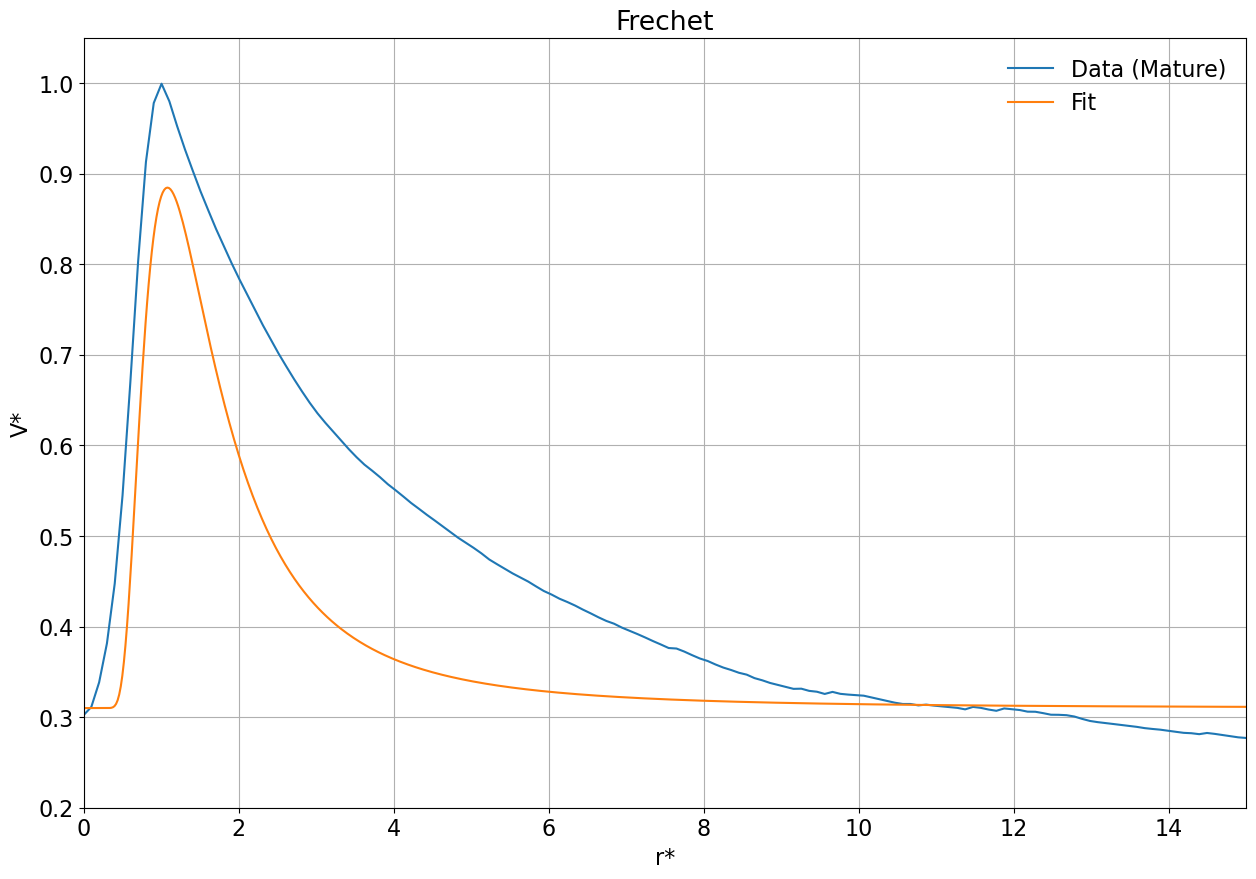

In [25]:
### 1) Test with Frechet

BDS = {
    'alpha': [0., 10.],
    's':     [0., 10.],
    'vmn':   [0.29, 0.31], 
}

popt, pcov = curve_fit(
    lambda x, alpha, s, vmn: vmn + frechet(x, alpha, s, m=0), 
    r_star[1:],         # Starting from r > 0
    V_____maturing[1:], 
    p0=[2, 1.2, 0.3], 
    bounds=(
        tuple([BDS[e][0] for e in BDS.keys()]),
        tuple([BDS[e][1] for e in BDS.keys()])
    ) 
) 

print(popt)

plt.title('Frechet')
plt.plot(r_star, V_____maturing, label='Data (Mature)')
plt.plot(xs, popt[2] + frechet(xs, popt[0], popt[1]), label='Fit')
plt.legend(frameon=False)
plt.grid()
plt.xlabel('r*')
plt.ylabel('V*')
plt.xlim(0, 15)
plt.ylim(0.2, 1.05)

[1.71103066 1.16266626 0.31      ]


/tmp/ipykernel_4309/167706122.py:22: RuntimeWarning: divide by zero encountered in power
  return (alpha / s) * ((x - m) / s) ** (-1 - alpha) * np.exp(-((x - m) / s) ** (-alpha))
/tmp/ipykernel_4309/167706122.py:22: RuntimeWarning: invalid value encountered in multiply
  return (alpha / s) * ((x - m) / s) ** (-1 - alpha) * np.exp(-((x - m) / s) ** (-alpha))


(0.2, 1.05)

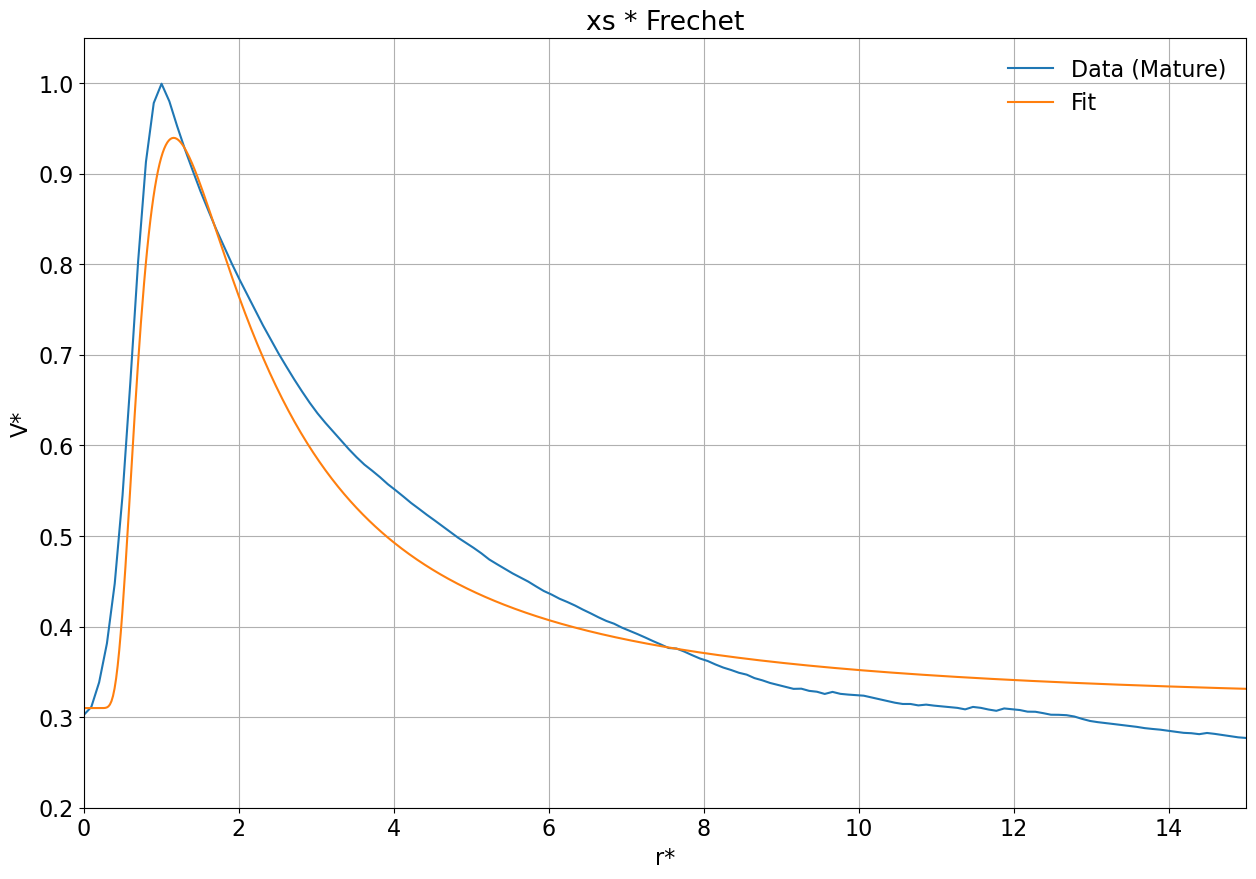

In [26]:
### 2) Test with xs * Frechet

BDS = {
    'alpha': [0., 10.],
    's':     [0., 10.],
    'vmn':   [0.29, 0.31], 
}

popt, pcov = curve_fit(
    lambda x, alpha, s, vmn: vmn + x * frechet(x, alpha, s, m=0), 
    r_star[1:],         # Starting from r > 0
    V_____maturing[1:], 
    p0=[2, 1.2, 0.3], 
    bounds=(
        tuple([BDS[e][0] for e in BDS.keys()]),
        tuple([BDS[e][1] for e in BDS.keys()])
    ) 
) 

print(popt)

plt.title('xs * Frechet')
plt.plot(r_star, V_____maturing, label='Data (Mature)')
plt.plot(xs, popt[2] + xs * frechet(xs, popt[0], popt[1]), label='Fit')
plt.legend(frameon=False)
plt.grid()
plt.xlabel('r*')
plt.ylabel('V*')
plt.xlim(0, 15)
plt.ylim(0.2, 1.05)

[1.88650551 0.93596789 0.29       1.476351  ]


/tmp/ipykernel_4309/167706122.py:22: RuntimeWarning: divide by zero encountered in power
  return (alpha / s) * ((x - m) / s) ** (-1 - alpha) * np.exp(-((x - m) / s) ** (-alpha))
/tmp/ipykernel_4309/167706122.py:22: RuntimeWarning: invalid value encountered in multiply
  return (alpha / s) * ((x - m) / s) ** (-1 - alpha) * np.exp(-((x - m) / s) ** (-alpha))


(0.2, 1.05)

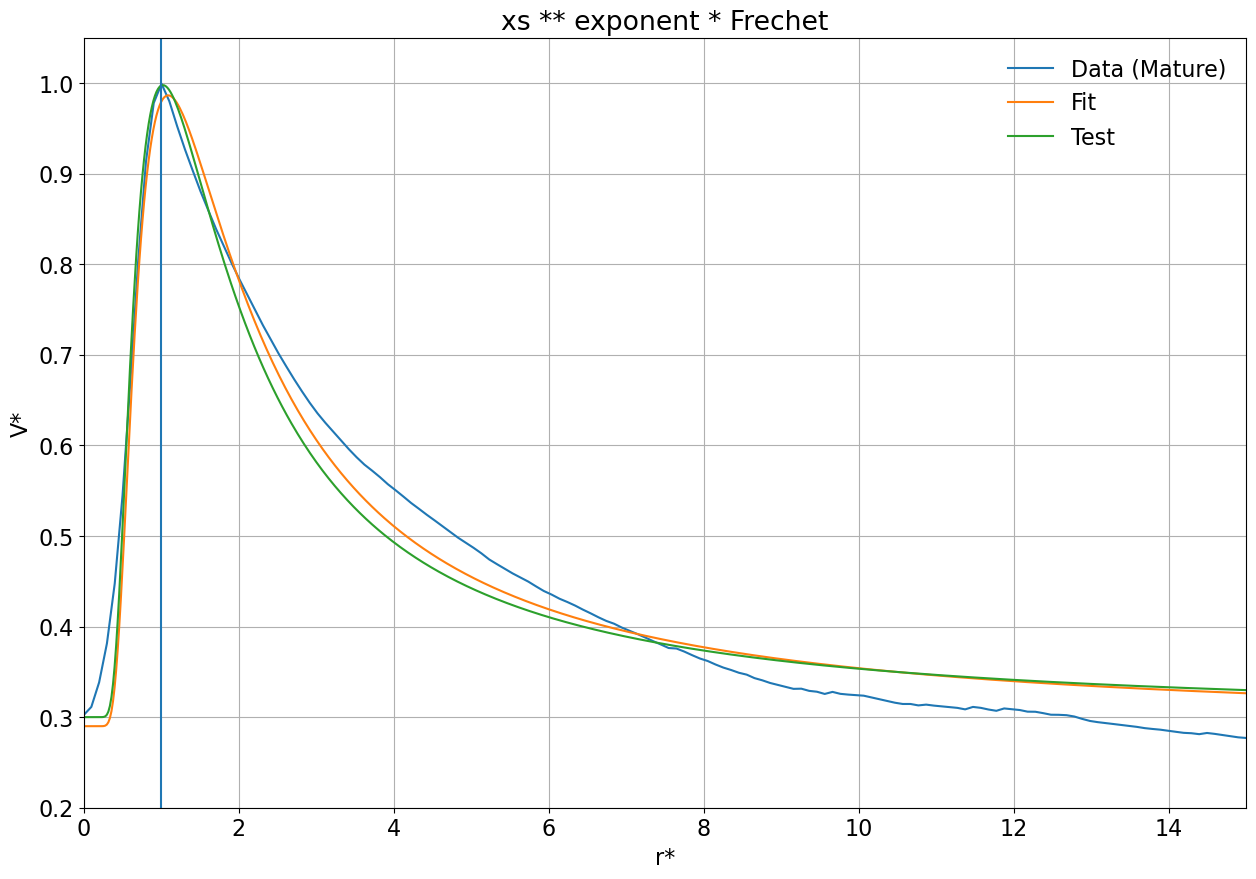

In [27]:
### 3) Test with xs ** exponent * Frechet

BDS = {
    'alpha':    [0., 10.],
    's':        [0., 10.],
    'vmn':      [0.29, 0.31], 
    'exponent': [0.1, 3.]
}

popt, pcov = curve_fit(
    lambda x, alpha, s, vmn, exponent: vmn + x ** exponent * frechet(x, alpha, s, m=0), 
    r_star[1:],         # Starting from r > 0
    V_____maturing[1:], 
    p0=[2, 1.2, 0.3, 1.], 
    bounds=(
        tuple([BDS[e][0] for e in BDS.keys()]),
        tuple([BDS[e][1] for e in BDS.keys()])
    ) 
) 

print(popt)

plt.title('xs ** exponent * Frechet')
plt.plot(r_star, V_____maturing, label='Data (Mature)')
plt.plot(xs, popt[2] + xs ** popt[3] * frechet(xs, popt[0], popt[1]), label='Fit')
plt.plot(xs, 0.3 + xs ** 1.5 * frechet(xs, 1.95, 0.88), label='Test')
plt.axvline(1)
plt.legend(frameon=False)
plt.grid()
plt.xlabel('r*')
plt.ylabel('V*')
plt.xlim(0, 15)
plt.ylim(0.2, 1.05)

[1.81291178]


/tmp/ipykernel_4309/167706122.py:40: RuntimeWarning: divide by zero encountered in divide
  return vmn + (1 - vmn) * np.sqrt(((1 / x) ** B) * np.exp(1 - (1 / x) ** B) + (x * c) ** 2) - x * c
/tmp/ipykernel_4309/167706122.py:40: RuntimeWarning: invalid value encountered in multiply
  return vmn + (1 - vmn) * np.sqrt(((1 / x) ** B) * np.exp(1 - (1 / x) ** B) + (x * c) ** 2) - x * c


(0.2, 1.05)

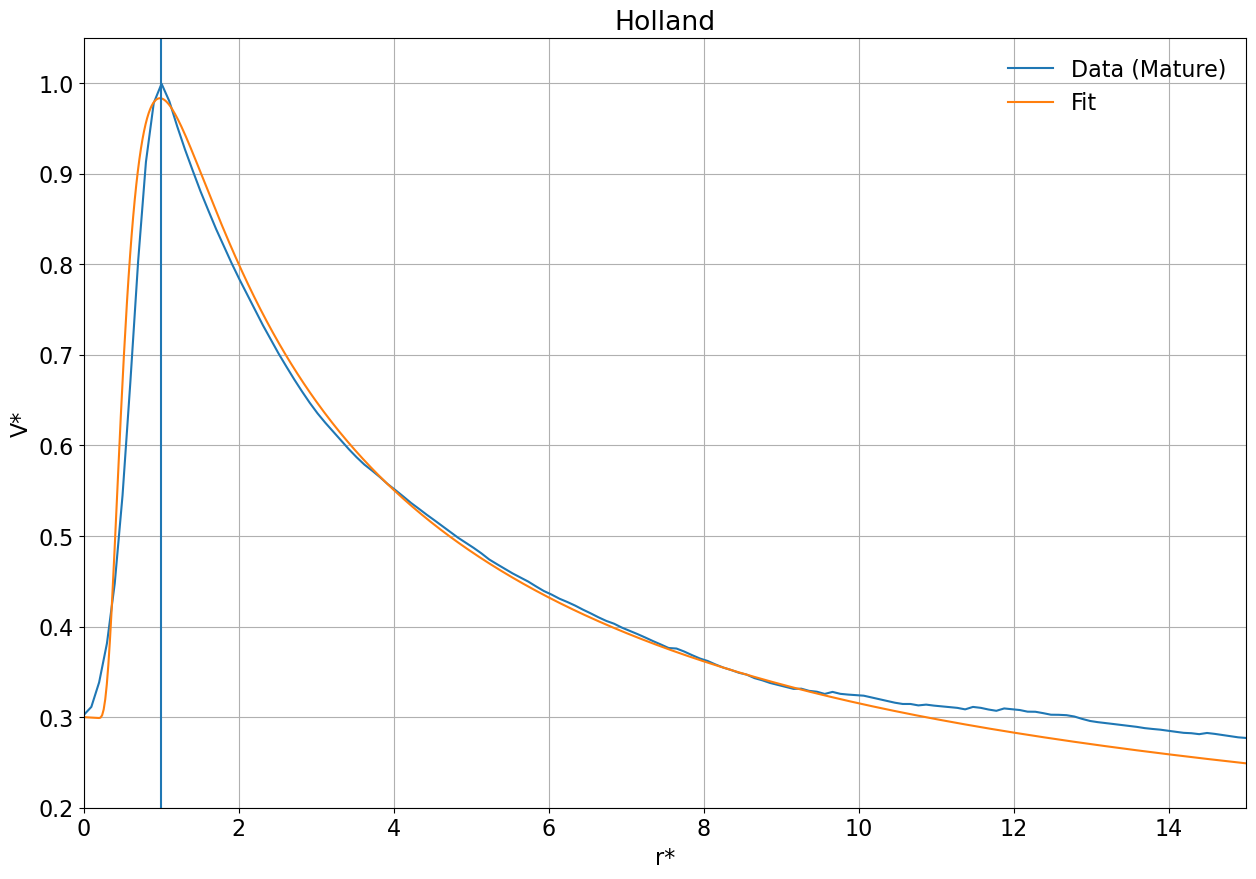

In [28]:
### 4) Test with Holland (cyclostrophic)

BDS = {
    'B':    [0., 10.],
}

popt, pcov = curve_fit(
    lambda x, B: holland_star(x, B, 0.3), 
    r_star[1:],         # Starting from r > 0
    V_____maturing[1:], 
    p0=[1.5], 
    bounds=(
        tuple([BDS[e][0] for e in BDS.keys()]),
        tuple([BDS[e][1] for e in BDS.keys()])
    ) 
) 

print(popt)

plt.title('Holland')
plt.plot(r_star, V_____maturing, label='Data (Mature)')
plt.plot(xs, holland_star(xs, popt[0], vmn=0.3), label='Fit')
# plt.plot(xs, 0.3 + xs ** 1.5 * frechet(xs, 1.95, 0.88), label='Test')
plt.axvline(1)
plt.legend(frameon=False)
plt.grid()
plt.xlabel('r*')
plt.ylabel('V*')
plt.xlim(0, 15)
plt.ylim(0.2, 1.05)

In [12]:
# # Hyperparameters
# width = 0.3

# fig        = plt.figure(figsize=(20, 20))
# gs         = GridSpec(2, 2, hspace=0.05, wspace=0.12)

# ############
# ### VMAX ###
# ############
# ax = fig.add_subplot(gs[0, 0])

# # Data pre.
# df                     = d[['basin_idx', 'vmx']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},
#     flierprops=dict(marker='x', color='grey'),
#     width=width,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# # xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# # g.set_xticklabels(xlabels)
# # g.set_xlabel('Basin')
# ax.set_xticklabels([])
# ax.set_xlabel('')
# g.set_ylabel(r'$V_{max}$ (m s$^{-1}$)')
# # ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background

# ############
# ### RMAX ###
# ############
# ax = fig.add_subplot(gs[0, 1])

# # Data pre.
# df                     = d[['basin_idx', 'rmx']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['rmx'])
# df_plot['value']       = df_plot['value'] / 1000
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},
#     flierprops=dict(marker='x', color='grey'),
#     width=width,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# # xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# # g.set_xticklabels(xlabels)
# # g.set_xlabel('Basin')
# ax.set_xticklabels([])
# ax.set_xlabel('')
# g.set_ylabel(r'$R_{max}$ (km)')
# # ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background

# ############
# ### FCOR ###
# ############
# ax = fig.add_subplot(gs[1, 0])

# # Data pre.
# df                     = d[['basin_idx', 'fcor']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['fcor'])
# df_plot['value']       = abs(df_plot['value'])
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},
#     flierprops=dict(marker='x', color='grey'),
#     width=width,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
# g.set_ylabel(r'$|f|$ (s$^{-1}$)')
# # ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background

# ############
# ### Rxx  ###
# ############
# ax = fig.add_subplot(gs[1, 1])

# # Data pre.
# df                     = d[['basin_idx', 'r34', 'r50', 'r64']].to_dataframe()
# df_plot                = df.melt(id_vars='basin_idx', value_vars=['r34', 'r50', 'r64'])
# df_plot['value']       = df_plot['value'] / 1000
# df_global              = df_plot.copy()
# df_global['basin_idx'] = 0
# df_combined            = pd.concat([df_plot, df_global])

# # Boxplot
# g = sns.boxplot(
#     x='basin_idx', 
#     y='value', 
#     hue='variable', 
#     data=df_combined, 
#     medianprops={'color': 'white'},], dtype='datetime64[ns]')
#     flierprops=dict(marker='x', color='grey'),
#     width=width * 3,
# )

# # Separation for All vs. basins
# ax.axvline(0.5, c='k', linewidth=2)

# # Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
# g.set_ylabel(r'$R_{34}$, $R_{50}$ and $R_{64}$ (km)')
# ax.legend(frameon=False, loc='upper center')
# # ax.legend_.remove()
# # Put the y ticks label ont the right 
# # The same can be done to put the xlabel at the top
# ax.yaxis.set_label_position("left") 
# plt.xticks(fontsize=fontsize - 2) #the x-ticks 
# plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# # Grids
# # Frame for the plot (do this after the right label position otherwise missing ticks)
# ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
# ax.spines['right'].set_linewidth(2)
# ax.spines['top'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)       
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# ax.set_axisbelow(True) # Set the grid in background